# Multi-armed Bandit Recommender System

## Env

In [70]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import Recommenders
import Bandits

## Dataset

In [7]:
events = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\events.csv')
categories = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\category_tree.csv')
item_properties_part1 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part1.csv')
item_properties_part2 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part2.csv')

In [8]:
# Concatenate item_properties_part1 and item_properties_part2
properties = pd.concat([item_properties_part1, item_properties_part2], ignore_index=True)

## Data Exploring, Cleaning and Feature Engineering

### Events

#### itemid

In [9]:
# Filter only events with itemid in properties
events = events[events['itemid'].isin(properties['itemid'])]

### Recommended items and user picking

#### Items

In [10]:
# Store the most representative purchased items
rec_items = events[events['event'] == 'transaction']['itemid']\
    .value_counts(normalize=True)\
        .sort_values(ascending=False)\
            .cumsum()\
                .loc[lambda x: x <= 0.8].index.tolist()

There might be some items that were purchased but not viewed or added to cart. These could be taken out of the recommended items list as we want optimize the user interaction in all ways with the purchased items

In [11]:
# Check if all items that were purchased were also viewed or added to cart
purchased_notviewed_notadded = events[((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'view']['itemid'])==False)) | 
       ((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'addtocart']['itemid'])==False))]['itemid'].unique()


In [12]:
# Remove the items that were purchased but not viewed or added to cart from the rec_items list
rec_items = [itm for itm in rec_items if itm not in purchased_notviewed_notadded]

### Properties

In [13]:
properties = properties[properties['itemid'].isin(events['itemid'].unique())]

In [14]:
# Convert 'timestamp' to datetime format
properties['timestamp'] = pd.to_datetime(properties['timestamp'], unit='ms', origin='unix')

#### Pre-processing properties

In [19]:
# Timestamp mínimo por itemid na tabela de propriedades
min_ts_props = properties_grouped.groupby('itemid')['timestamp'].min()

# Merge para trazer a data mínima das propriedades para os eventos
events_filtered = events.merge(
    min_ts_props.rename('min_prop_ts'), 
    on='itemid', 
    how='left'
)

# Filtra eventos ocorridos após a primeira propriedade do item
events_filtered = events_filtered[events_filtered['timestamp'] >= events_filtered['min_prop_ts']]
events_filtered = events_filtered.drop(columns='min_prop_ts')

NameError: name 'properties_grouped' is not defined

In [15]:
# Ordena para merge_asof
events_filtered = events_filtered.sort_values(['timestamp', 'itemid'])
properties_grouped = properties_grouped.sort_values(['timestamp', 'itemid'])

# Junta o contexto mais recente antes de cada evento
df_merged = pd.merge_asof(
    events_filtered,
    properties_grouped[['itemid', 'timestamp', 'context']],
    on='timestamp',
    by='itemid',
    direction='backward'
)

NameError: name 'events_filtered' is not defined

### Categories

In [16]:
rootcat = categories[categories['parentid'].isnull()]
firstgencat = categories[categories['parentid'].isin(rootcat['categoryid'])]
secondgencat = categories[categories['parentid'].isin(firstgencat['categoryid'])]
thirdgencat = categories[categories['parentid'].isin(secondgencat['categoryid'])]
fourthgencat = categories[categories['parentid'].isin(thirdgencat['categoryid'])]
fifthgencat = categories[categories['parentid'].isin(fourthgencat['categoryid'])]

In [17]:
root = rootcat.rename(columns={'categoryid': 'root'}).drop(columns='parentid')
layer_1 = firstgencat.rename(columns={'categoryid': 'layer_1', 'parentid': 'root'})
layer_2 = secondgencat.rename(columns={'categoryid': 'layer_2', 'parentid': 'layer_1'})
layer_3 = thirdgencat.rename(columns={'categoryid': 'layer_3', 'parentid': 'layer_2'})
layer_4 = fourthgencat.rename(columns={'categoryid': 'layer_4', 'parentid': 'layer_3'})
layer_5 = fifthgencat.rename(columns={'categoryid': 'layer_5', 'parentid': 'layer_4'})

In [18]:
tree_l5 = layer_5.merge(layer_4, on='layer_4').merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l4 = layer_4.merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l3 = layer_3.merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l2 = layer_2.merge(layer_1, on='layer_1').merge(root, on='root')
tree_l1 = layer_1.merge(root, on='root')
cat_tree = pd.concat([tree_l1, tree_l2, tree_l3, tree_l4, tree_l5], ignore_index=True)

In [19]:
neworder = ['root','layer_1','layer_2','layer_3','layer_4','layer_5']
cat_tree = cat_tree.reindex(neworder, axis=1).sort_values(by=neworder)
cat_tree

,root,layer_1,layer_2,layer_3,layer_4,layer_5
1151,140.0,61.0,323.0,1558.0,NaN,NaN
760,140.0,61.0,323.0,NaN,NaN,NaN
1153,140.0,61.0,897.0,120.0,NaN,NaN
1007,140.0,61.0,897.0,1098.0,NaN,NaN
1528,140.0,61.0,897.0,1317.0,NaN,NaN
...,...,...,...,...,...,...
732,1698.0,1678.0,305.0,NaN,NaN,NaN
730,1698.0,1678.0,455.0,NaN,NaN,NaN
779,1698.0,1678.0,1346.0,NaN,NaN,NaN
731,1698.0,1678.0,1554.0,NaN,NaN,NaN


## MAB Implementation

In [20]:
#
prop_test = properties[properties['property']=='categoryid']
prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms', origin='unix')

C:\Users\fldam\AppData\Local\Temp\ipykernel_12464\4038205902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')


In [33]:
# Verifying the event distribution for the most frequent visitor
events[events['visitorid'] == events['visitorid'].value_counts().index[1]]['event'].value_counts()

event
view           2738
addtocart       405
transaction     276
Name: count, dtype: int64

In [22]:
maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[1]]
maxvisitor_events

,timestamp,visitorid,event,itemid,transactionid
261793,2015-06-16 00:13:01.237,530559,view,371551,NaN
263557,2015-06-15 20:02:25.898,530559,view,21988,NaN
263568,2015-06-15 19:36:51.103,530559,transaction,362858,14083.0
263581,2015-06-15 19:36:51.103,530559,transaction,439963,14083.0
263739,2015-06-15 19:05:08.755,530559,view,360487,NaN
...,...,...,...,...,...
2735359,2015-07-30 20:45:04.651,530559,view,323030,NaN
2735417,2015-07-30 20:44:37.034,530559,view,234613,NaN
2735789,2015-07-30 20:03:36.825,530559,view,450930,NaN
2735877,2015-07-30 20:06:10.165,530559,addtocart,450930,NaN


In [23]:
merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()

validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])

resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
resultado

,timestamp_x,visitorid,event,itemid,transactionid,value
0,2015-06-28 02:06:38.029,530559,view,66,NaN,1080
1,2015-06-28 02:07:01.514,530559,view,66,NaN,1080
2,2015-08-22 16:19:32.715,530559,view,546,NaN,1349
3,2015-08-22 20:36:35.754,530559,view,546,NaN,1349
4,2015-08-24 15:33:34.130,530559,view,546,NaN,1349
...,...,...,...,...,...,...
3269,2015-07-20 01:51:34.719,530559,view,466488,NaN,352
3270,2015-09-15 16:46:25.863,530559,view,466603,NaN,126
3271,2015-09-15 16:46:33.419,530559,addtocart,466603,NaN,126
3272,2015-09-15 23:25:12.901,530559,view,466603,NaN,126


In [24]:
# Transform column 'value' into a list of integers
resultado['value'] = resultado['value'].apply(lambda x: int(x))

In [25]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()
resultado['_cat_id'] = resultado['value'].map(mapa_categoria)

resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
resultado_final

,timestamp_x,visitorid,event,itemid,transactionid,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-06-28 02:06:38.029,530559,view,66,NaN,1080,653.0,312.0,1281.0,1080.0,NaN,NaN
1,2015-06-28 02:07:01.514,530559,view,66,NaN,1080,653.0,312.0,1281.0,1080.0,NaN,NaN
2,2015-08-22 16:19:32.715,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
3,2015-08-22 20:36:35.754,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
4,2015-08-24 15:33:34.130,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3269,2015-07-20 01:51:34.719,530559,view,466488,NaN,352,859.0,352.0,NaN,NaN,NaN,NaN
3270,2015-09-15 16:46:25.863,530559,view,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN
3271,2015-09-15 16:46:33.419,530559,addtocart,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN
3272,2015-09-15 23:25:12.901,530559,view,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN


In [26]:
resultado_final['root'] = np.nan_to_num(resultado_final['root'])
resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])

In [27]:
# Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
resultado_final['context'] = resultado_final.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

In [28]:
context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})

In [29]:
context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
context_events

,timestamp,itemid,context,event
0,2015-06-28 02:06:38.029,66,"[653.0, 312.0, 1281.0, 1080.0, 0.0, 0.0]",view
1,2015-06-28 02:07:01.514,66,"[653.0, 312.0, 1281.0, 1080.0, 0.0, 0.0]",view
2,2015-08-22 16:19:32.715,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
3,2015-08-22 20:36:35.754,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
4,2015-08-24 15:33:34.130,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
...,...,...,...,...
3269,2015-07-20 01:51:34.719,466488,"[859.0, 352.0, 0.0, 0.0, 0.0, 0.0]",view
3270,2015-09-15 16:46:25.863,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",view
3271,2015-09-15 16:46:33.419,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",addtocart
3272,2015-09-15 23:25:12.901,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",view


In [30]:
# Transform every row in cat_tree into a vector
def vectorize_categories(cat_tree):
    vectors = []
    for _, row in cat_tree.iterrows():
        vector = []
        for col in ['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']:
            vector.append(row[col])
        vectors.append(vector)
    return np.array(vectors)

In [31]:
cat_vectors = vectorize_categories(cat_tree)
cat_vectors = np.nan_to_num(cat_vectors)
cat_vectors

array([[ 140.,   61.,  323., 1558.,    0.,    0.],
       [ 140.,   61.,  323.,    0.,    0.,    0.],
       [ 140.,   61.,  897.,  120.,    0.,    0.],
       ...,
       [1698., 1678., 1346.,    0.,    0.,    0.],
       [1698., 1678., 1554.,    0.,    0.,    0.],
       [1698., 1678.,    0.,    0.,    0.,    0.]], shape=(1644, 6))

In [32]:
rec_items_test = prop_test[prop_test['itemid'].isin(rec_items)]
rec_items_test

,timestamp,itemid,property,value
1441,2015-05-10 03:00:00,38175,categoryid,196
5312,2015-05-10 03:00:00,285055,categoryid,1167
5914,2015-06-28 03:00:00,172842,categoryid,366
7554,2015-06-28 03:00:00,282528,categoryid,366
9009,2015-07-19 03:00:00,190070,categoryid,1613
...,...,...,...,...
20270731,2015-09-06 03:00:00,321668,categoryid,438
20271676,2015-08-16 03:00:00,151125,categoryid,224
20272305,2015-05-31 03:00:00,150857,categoryid,1135
20272703,2015-05-24 03:00:00,190594,categoryid,705


In [33]:
# Transform column 'value' into a list of integers
prop_test['value'] = prop_test['value'].apply(lambda x: int(x))

# Map 'value' to '_cat_id' using mapa_categoria
prop_test['_cat_id'] = prop_test['value'].map(mapa_categoria)

# Map 'value' to 'category' using cat_tree
prop_test = prop_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])

C:\Users\fldam\AppData\Local\Temp\ipykernel_12464\2656633147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['value'] = prop_test['value'].apply(lambda x: int(x))
C:\Users\fldam\AppData\Local\Temp\ipykernel_12464\2656633147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['_cat_id'] = prop_test['value'].map(mapa_categoria)


In [34]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()

rec_items_test['value'] = rec_items_test['value'].apply(lambda x: int(x))

rec_items_test['_cat_id'] = rec_items_test['value'].map(mapa_categoria)

rec_items_test = rec_items_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
rec_items_test

,timestamp,itemid,property,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-05-10 03:00:00,38175,categoryid,196,140.0,409.0,1667.0,196.0,NaN,NaN
1,2015-05-10 03:00:00,285055,categoryid,1167,250.0,1167.0,NaN,NaN,NaN,NaN
2,2015-06-28 03:00:00,172842,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
3,2015-06-28 03:00:00,282528,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
4,2015-07-19 03:00:00,190070,categoryid,1613,250.0,1613.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14064,2015-09-06 03:00:00,321668,categoryid,438,653.0,312.0,438.0,NaN,NaN,NaN
14065,2015-08-16 03:00:00,151125,categoryid,224,140.0,920.0,1487.0,224.0,NaN,NaN
14066,2015-05-31 03:00:00,150857,categoryid,1135,140.0,1519.0,1329.0,1135.0,NaN,NaN
14067,2015-05-24 03:00:00,190594,categoryid,705,140.0,920.0,1487.0,705.0,NaN,NaN


In [35]:
prop_test['root'] = np.nan_to_num(prop_test['root'])
prop_test['layer_1'] = np.nan_to_num(prop_test['layer_1'])
prop_test['layer_2'] = np.nan_to_num(prop_test['layer_2'])
prop_test['layer_3'] = np.nan_to_num(prop_test['layer_3'])
prop_test['layer_4'] = np.nan_to_num(prop_test['layer_4'])
prop_test['layer_5'] = np.nan_to_num(prop_test['layer_5'])

prop_test['context'] = prop_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

prop_test = prop_test[['timestamp', 'itemid','context']]

In [36]:
rec_items_test['root'] = np.nan_to_num(rec_items_test['root'])
rec_items_test['layer_1'] = np.nan_to_num(rec_items_test['layer_1'])
rec_items_test['layer_2'] = np.nan_to_num(rec_items_test['layer_2'])
rec_items_test['layer_3'] = np.nan_to_num(rec_items_test['layer_3'])
rec_items_test['layer_4'] = np.nan_to_num(rec_items_test['layer_4'])
rec_items_test['layer_5'] = np.nan_to_num(rec_items_test['layer_5'])

rec_items_test['context'] = rec_items_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

rec_items_test = rec_items_test[['timestamp', 'itemid','context']]

In [37]:
context_events.sort_values(by='timestamp', inplace=True)

In [38]:
rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                <= context_events['timestamp'].max()].sort_values(by='timestamp')

In [31]:
# Instancia o modelo
n_features = len(context_events.iloc[0]['context'])
modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

# Simula
df_resultado_usuario = Recommenders.simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [32]:
context_events['event'].value_counts()

event
view           2610
addtocart       396
transaction     268
Name: count, dtype: int64

In [33]:
df_resultado_usuario['reward'].value_counts().sort_index()

reward
0.0    2619
0.1     209
0.5     267
1.0     149
Name: count, dtype: int64

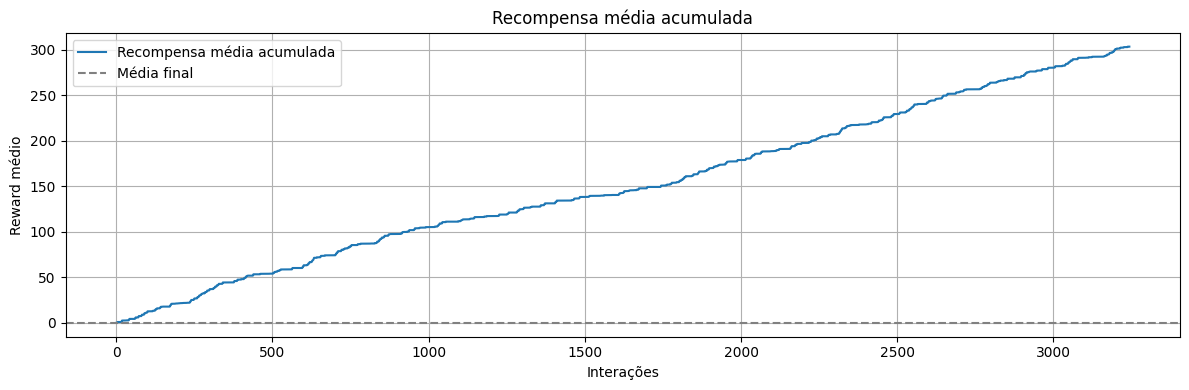

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].cumsum(), label='Recompensa acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

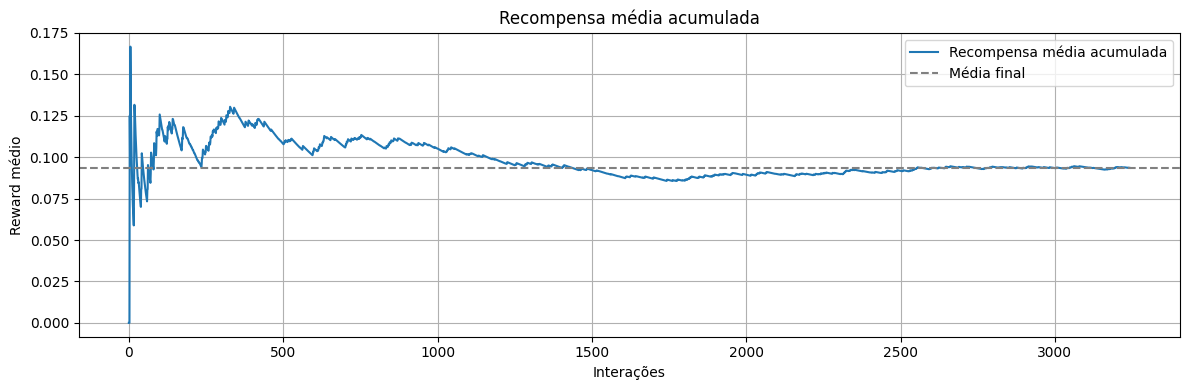

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
weights = modelo_usuario.weights
weights_df = pd.DataFrame.from_dict(weights, orient='index')
weights_df

,0,1,2,3,4,5
393768,-3.244856e+13,-3.415211e+13,-3.257024e+13,-1.385148e+13,0.000000e+00,0.0
369158,-3.280163e+13,-3.452371e+13,-3.292463e+13,-1.066053e+13,-9.635478e+12,0.0
362858,-5.909535e+07,-4.358860e+06,-1.654824e+07,0.000000e+00,0.000000e+00,0.0
439963,-1.742607e+91,-3.332793e+90,-1.212545e+91,-9.020154e+90,0.000000e+00,0.0
371551,-4.861012e+15,-1.420110e+16,-3.802006e+16,-3.329794e+16,-2.413145e+16,0.0
...,...,...,...,...,...,...
410056,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
375876,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
461190,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
451703,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [ ]:
# Define a function to pick n top users based on the number of events and process the dataset for each user
def process_top_n_users(n):
    # Loop through the top n users
    for i in range(n):
        # Get the events for the current user
        maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[i]]
        # Merge with property test
        merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
        # Filter valid properties
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        # Calculate time difference
        validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])
        # Get the closest property for each event
        resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
        # Drop unnecessary columns
        resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
        # Transform column 'value' into a list of integers
        resultado['value'] = resultado['value'].apply(lambda x: int(x))
        # Map 'value' to '_cat_id' using mapa_categoria
        resultado['_cat_id'] = resultado['value'].map(mapa_categoria)
        # Merge with cat_tree to get category layers
        resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
        # Handle NaN values in category layers
        resultado_final['root'] = np.nan_to_num(resultado_final['root'])
        resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
        resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
        resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
        resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
        resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])
        # Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
        resultado_final['context'] = resultado_final.apply(lambda row: \
                                                                    [row['root'],row['layer_1'],row['layer_2'], \
                                                                    row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
        # Prepare context_events for the user
        context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})
        # Transform 'context' column to numpy array
        context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
        # Filter rec_items_test to include only items within the timestamp range of context_events
        rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                        <= context_events['timestamp'].max()].sort_values(by='timestamp')
        # Instantiates the model
        n_features = len(context_events.iloc[0]['context'])
        modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

        # For each user, simulate the recommendation and store the result separately with the user index in the filename
        df_resultado_usuario = pd.DataFrame()
        # Create a unique variable name for each user result
        globals()[f'df_resultado_usuario_{i}'] = Recommenders.simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [39]:
def process_top_n_users(n, events, prop_test, rec_items_test, mapa_categoria, cat_tree):
    """
    Process the top-n users by event count and simulate recommendations for each user.

    Parameters
    ----------
    n : int -> Number of top users to process.
    events : pd.DataFrame -> Event dataset containing 'visitorid', 'itemid', 'timestamp', 'event'.
    prop_test : pd.DataFrame -> Property dataset containing 'itemid', 'timestamp', 'value'.
    rec_items_test : pd.DataFrame -> Recommendation items dataset containing 'itemid', 'timestamp'.
    mapa_categoria : dict -> Mapping of property values to category IDs.
    cat_tree : pd.DataFrame -> Category tree containing category layers for each `_cat_id`.

    Returns
    -------
    dict
        Dictionary mapping user_rank (0..n-1) -> result DataFrame.
    """
    results = {}

    # Select top-n users by event count
    top_users = events['visitorid'].value_counts().index[:n]

    for i, user_id in enumerate(top_users):
        # Get events for the current user
        user_events = events[events['visitorid'] == user_id]

        # Merge with property test
        merged = user_events.merge(prop_test, on='itemid', how='left')

        # Keep only valid properties
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        if validos.empty:
            continue

        # Calculate time difference
        validos['time_diff'] = validos['timestamp_x'] - validos['timestamp_y']

        # Get the closest property for each event
        resultado = validos.loc[
            validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()
        ].reset_index(drop=True)

        # Drop unnecessary columns
        resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True, errors="ignore")

        # Convert 'value' safely to integer
        resultado['value'] = pd.to_numeric(resultado['value'], errors='coerce').fillna(0).astype(int)

        # Map 'value' to '_cat_id'
        resultado['_cat_id'] = resultado['value'].map(mapa_categoria)

        # Merge with cat_tree
        resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])

        # Fill NaNs with 0 and cast to int
        layer_cols = ['root','layer_1','layer_2','layer_3','layer_4','layer_5']
        resultado_final[layer_cols] = resultado_final[layer_cols].fillna(0).astype(int)

        # Build context vectors
        resultado_final['context'] = resultado_final[layer_cols].values.tolist()

        # Prepare context_events
        context_events = resultado_final[['timestamp_x', 'itemid', 'context', 'event']].rename(
            columns={'timestamp_x': 'timestamp'}
        )
        context_events['context'] = context_events['context'].apply(lambda x: np.array(x))

        # Filter rec_items_test for this user
        rec_items_test_user = rec_items_test[
            rec_items_test['timestamp'] <= context_events['timestamp'].max()
        ].sort_values(by='timestamp').copy()

        if context_events.empty or rec_items_test_user.empty:
            continue

        # Instantiate model
        n_features = len(context_events.iloc[0]['context'])
        modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

        # Run recommender
        result_df = Recommenders.simular_recomendacao_top5_epsilon_greedy(
            context_events, rec_items_test_user, modelo_usuario
        )

        # Store result for this user's rank index
        results[i] = result_df

    return results

In [59]:
# First, make sure to import the required classes at the top of your script
from Bandits import EpsilonGreedy  # Import your EpsilonGreedy class
from Recommenders import simular_recomendacao_top5_epsilon_greedy  # Import your recommender function
import numpy as np
import pandas as pd

def process_top_n_users(n, events, prop_test, rec_items_test, mapa_categoria, cat_tree):
    """
    Process the top-n users by event count and simulate recommendations for each user.
    """
    results = {}
    
    print(f"Processing top {n} users...")
    
    # Precompute top users
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    
    for i, user_id in enumerate(top_users):
        try:
            print(f"Processing user {i+1}/{n}: {user_id}")
            
            # Get user events
            user_mask = events['visitorid'] == user_id
            user_events = events.loc[user_mask].copy()
            
            if user_events.empty:
                print(f"  No events for user {user_id}")
                continue

            # Merge with property test to get context
            merged = pd.merge(
                user_events, 
                prop_test[['itemid', 'timestamp', 'context']], 
                on='itemid', 
                how='inner',
                suffixes=('_event', '_prop')
            )
            
            if merged.empty:
                print(f"  No matching properties for user {user_id}")
                continue

            # Filter for valid properties (property timestamp <= event timestamp)
            valid_mask = merged['timestamp_prop'] <= merged['timestamp_event']
            validos = merged.loc[valid_mask].copy()
            
            if validos.empty:
                print(f"  No valid properties for user {user_id}")
                continue

            # Find the most recent property for each event
            validos['time_diff'] = validos['timestamp_event'] - validos['timestamp_prop']
            min_time_diff = validos.groupby(['itemid', 'timestamp_event'])['time_diff'].transform('min')
            closest_mask = validos['time_diff'] == min_time_diff
            
            resultado = validos.loc[closest_mask].drop_duplicates(
                subset=['itemid', 'timestamp_event'], 
                keep='first'
            ).reset_index(drop=True)

            # Clean up columns
            cols_to_drop = ['timestamp_prop', 'time_diff', 'transactionid']
            cols_to_drop = [col for col in cols_to_drop if col in resultado.columns]
            resultado.drop(columns=cols_to_drop, inplace=True)

            # Convert context from list to numpy array (much more efficient)
            print(f"  Converting context from list to numpy arrays...")
            resultado['context'] = resultado['context'].apply(lambda x: np.array(x, dtype=np.float32))
            
            # Prepare context_events
            context_events = resultado[['timestamp_event', 'itemid', 'context', 'event']].rename(
                columns={'timestamp_event': 'timestamp'}
            )

            # Filter rec_items_test for this user's timeframe
            max_timestamp = context_events['timestamp'].max()
            rec_items_test_user = rec_items_test[
                rec_items_test['timestamp'] <= max_timestamp
            ].copy()

            if context_events.empty or rec_items_test_user.empty:
                print(f"  Empty context events or recommendation items for user {user_id}")
                continue

            # Convert rec_items_test context to numpy arrays
            if 'context' in rec_items_test_user.columns:
                rec_items_test_user['context'] = rec_items_test_user['context'].apply(
                    lambda x: np.array(x, dtype=np.float32) if isinstance(x, list) else x
                )
            else:
                # If rec_items_test doesn't have context, get latest from prop_test
                print(f"  rec_items_test missing context, merging with latest properties...")
                latest_props = prop_test.loc[prop_test.groupby('itemid')['timestamp'].idxmax()]
                rec_items_test_user = pd.merge(
                    rec_items_test_user,
                    latest_props[['itemid', 'context']],
                    on='itemid',
                    how='left'
                )
                rec_items_test_user['context'] = rec_items_test_user['context'].apply(
                    lambda x: np.array(x, dtype=np.float32) if isinstance(x, list) else np.array([0], dtype=np.float32)
                )

            # Instantiate model
            n_features = len(context_events.iloc[0]['context'])
            modelo_usuario = EpsilonGreedy(epsilon=0.3, n_features=n_features, learning_rate=0.1)

            print(f"  Running recommender with {len(context_events)} events and {len(rec_items_test_user)} candidate items")
            print(f"  Context dimension: {n_features}")
            
            # Run recommender
            result_df = simular_recomendacao_top5_epsilon_greedy(
                context_events, rec_items_test_user, modelo_usuario
            )

            results[i] = result_df
            print(f"  Completed user {user_id} with {len(result_df)} recommendations")

        except Exception as e:
            print(f"Error processing user {user_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    return results

In [64]:
import numpy as np
import pandas as pd
from Bandits import EpsilonGreedy
from Recommenders import simular_recomendacao_top5_epsilon_greedy
from bisect import bisect_right
import time

def process_top_n_users_optimized(n, events, prop_test, rec_items_test, mapa_categoria, cat_tree):
    """
    Highly optimized version for large datasets, updated for new bandit/recommender.
    """
    results = {}
    
    print(f"Processing top {n} users...")
    
    # Precompute top users
    top_users = events['visitorid'].value_counts().nlargest(n).index.tolist()
    
    # Pre-sort and preprocess data for faster access
    events_sorted = events.sort_values('visitorid').set_index('visitorid', drop=False)
    prop_test_sorted = prop_test.sort_values('itemid').set_index('itemid', drop=False)
    rec_items_sorted = rec_items_test.sort_values('timestamp')
    
    # Precompute latest context for each item (for recommendation candidates)
    print("Precomputing latest item contexts...")
    latest_contexts = prop_test_sorted.loc[prop_test_sorted.groupby('itemid')['timestamp'].idxmax()]
    
    # Convert contexts to numpy arrays efficiently
    item_context_map = {}
    for item_id, row in latest_contexts.iterrows():
        context = row['context']
        if isinstance(context, (list, np.ndarray)):
            item_context_map[item_id] = np.array(context, dtype=np.float32)
        else:
            item_context_map[item_id] = np.array([0], dtype=np.float32)
    
    for i, user_id in enumerate(top_users):
        user_start_time = time.time()
        try:
            print(f"\nProcessing user {i+1}/{n}: {user_id}")
            
            # Fast user events retrieval using pre-sorted index
            user_events = events_sorted.loc[[user_id]].copy()
            if user_events.empty:
                continue
                
            print(f"  User has {len(user_events)} events")

            # Batch process: get all unique items for this user
            user_items = user_events['itemid'].unique()
            
            # Fast property lookup using pre-sorted index
            user_props = prop_test_sorted.loc[prop_test_sorted.index.intersection(user_items)].copy()
            if user_props.empty:
                continue

            # Vectorized timestamp filtering and context assignment
            print("  Processing events with optimized operations...")
            
            # Create event-property pairs efficiently using vectorized operations
            event_prop_pairs = []
            
            # Group events by item for efficient processing
            for item_id in user_items:
                item_events = user_events[user_events['itemid'] == item_id]
                item_props = user_props[user_props.index == item_id]
                
                if not item_props.empty:
                    # Get the latest property for this item
                    latest_prop = item_props.nlargest(1, 'timestamp').iloc[0]
                    latest_context = latest_prop['context']
                    
                    # Convert context to numpy array if needed
                    if isinstance(latest_context, (list, np.ndarray)):
                        context_array = np.array(latest_context, dtype=np.float32)
                    else:
                        context_array = np.array([0], dtype=np.float32)
                    
                    # Assign this context to all events for this item
                    for _, event_row in item_events.iterrows():
                        event_prop_pairs.append({
                            'timestamp': event_row['timestamp'],
                            'itemid': item_id,
                            'context': context_array,
                            'event': event_row['event']
                        })

            if not event_prop_pairs:
                continue
                
            # Create context_events DataFrame efficiently
            context_events = pd.DataFrame(event_prop_pairs)
            
            # Filter rec_items_test for this user's timeframe
            max_timestamp = context_events['timestamp'].max()
            time_filter = rec_items_sorted['timestamp'] <= max_timestamp
            rec_items_test_user = rec_items_sorted[time_filter].copy()
            
            if rec_items_test_user.empty:
                continue
                
            # Assign contexts to recommendation items using precomputed map
            print(f"  Assigning contexts to {len(rec_items_test_user)} candidate items...")
            rec_contexts = []
            for item_id in rec_items_test_user['itemid']:
                rec_contexts.append(item_context_map.get(item_id, np.array([0], dtype=np.float32)))
            
            rec_items_test_user = rec_items_test_user.copy()
            rec_items_test_user['context'] = rec_contexts

            print(f"  {len(context_events)} events, {len(rec_items_test_user)} candidate items")
            
            # Use the optimized model configuration
            n_features = len(context_events.iloc[0]['context'])
            modelo_usuario = EpsilonGreedy(
                epsilon=0.3, 
                n_features=n_features, 
                learning_rate=0.05
            )

            # Run the optimized recommender
            print("  Running optimized recommender simulation...")
            result_df = simular_recomendacao_top5_epsilon_greedy_unlimited(
                context_events, 
                rec_items_test_user, 
                modelo_usuario,
                warmup=30
            )

            results[i] = result_df
            
            user_time = time.time() - user_start_time
            print(f"  Completed in {user_time:.2f}s - {len(result_df)} recommendations")

        except Exception as e:
            print(f"Error processing user {user_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    return results

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rec_items_test.sort_values(by='timestamp', inplace=True)

,timestamp,itemid,context
0,2015-05-10 03:00:00,38175,"[140.0, 409.0, 1667.0, 196.0, 0.0, 0.0]"
9496,2015-05-10 03:00:00,272733,"[1224.0, 105.0, 1421.0, 0.0, 0.0, 0.0]"
6201,2015-05-10 03:00:00,276240,"[1532.0, 1299.0, 594.0, 686.0, 0.0, 0.0]"
6199,2015-05-10 03:00:00,217617,"[140.0, 540.0, 121.0, 1228.0, 838.0, 0.0]"
6198,2015-05-10 03:00:00,218033,"[1224.0, 1443.0, 1546.0, 1006.0, 0.0, 0.0]"
...,...,...,...
12862,2015-09-13 03:00:00,348668,"[1532.0, 113.0, 282.0, 0.0, 0.0, 0.0]"
2667,2015-09-13 03:00:00,270534,"[140.0, 164.0, 396.0, 0.0, 0.0, 0.0]"
229,2015-09-13 03:00:00,98012,"[1482.0, 381.0, 47.0, 423.0, 0.0, 0.0]"
13908,2015-09-13 03:00:00,63651,"[679.0, 491.0, 0.0, 0.0, 0.0, 0.0]"


In [51]:
import torch
import random
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from tqdm.auto import tqdm  # opcional para barra de progresso
import Bandits
import Recommenders

# ----------------------------
# Utilitário: construir mapeamento itemid -> index
# ----------------------------
def build_item_index(rec_items_df: pd.DataFrame) -> Tuple[Dict[int,int], List[int]]:
    """
    Recebe rec_items_df com coluna 'itemid' (única lista de itens do catálogo)
    Retorna dict itemid->index e lista de itemids (index->itemid)
    """
    unique_items = rec_items_df['itemid'].unique()
    itemid_to_index = {int(item): idx for idx, item in enumerate(unique_items)}
    index_to_itemid = list(unique_items)
    return itemid_to_index, index_to_itemid


# ----------------------------
# Função process_top_n_users (adaptada) que usa a simulação PyTorch
# ----------------------------
def process_top_n_users_torch(
    n: int,
    events: pd.DataFrame,
    prop_test: pd.DataFrame,
    rec_items_test: pd.DataFrame,
    mapa_categoria: Dict[int,int],
    cat_tree: pd.DataFrame,
    top_k: int = 5,
    warmup: int = 30,
    device: str = None,
    use_tqdm: bool = True
) -> Dict[int, pd.DataFrame]:
    results = {}
    top_users = events['visitorid'].value_counts().index[:n]

    # Construir mapeamento global de items (baseado em rec_items_test)
    itemid_to_index, index_to_itemid = build_item_index(rec_items_test)
    n_items = len(index_to_itemid)

    for i, user_id in enumerate(top_users):
        # Extração e merge (mantendo lógica original)
        user_events = events[events['visitorid'] == user_id]
        merged = user_events.merge(prop_test, on='itemid', how='left')
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        if validos.empty:
            continue
        validos['time_diff'] = validos['timestamp_x'] - validos['timestamp_y']
        resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
        resultado.drop(columns=['timestamp_y','time_diff','property'], inplace=True, errors="ignore")
        resultado['value'] = pd.to_numeric(resultado['value'], errors='coerce').fillna(0).astype(int)
        resultado['_cat_id'] = resultado['value'].map(mapa_categoria)
        resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
        layer_cols = ['root','layer_1','layer_2','layer_3','layer_4','layer_5']
        resultado_final[layer_cols] = resultado_final[layer_cols].fillna(0).astype(int)
        resultado_final['context'] = resultado_final[layer_cols].values.tolist()
        context_events = resultado_final[['timestamp_x','itemid','context','event']].rename(columns={'timestamp_x':'timestamp'})
        context_events['context'] = context_events['context'].apply(lambda x: np.array(x))

        # Filtra rec_items_test até o ultimo timestamp do usuário
        rec_items_user = rec_items_test[rec_items_test['timestamp'] <= context_events['timestamp'].max()].sort_values(by='timestamp').copy()
        if context_events.empty or rec_items_user.empty:
            continue

        # Instancia o modelo PyTorch
        n_features = len(context_events.iloc[0]['context'])
        model = EpsilonGreedyTorch(
            epsilon=0.3,
            n_items=n_items,
            n_features=n_features,
            learning_rate=0.05,
            normalize_weights=True,
            device=device
        )

        # Rodar simulação vetorizada
        result_df = simular_recomendacao_top_k_epsilon_greedy_torch(
            context_events=context_events,
            catalog_df=rec_items_user,
            model=model,
            itemid_to_index=itemid_to_index,
            top_k=top_k,
            warmup=warmup,
            use_tqdm=use_tqdm
        )

        results[i] = result_df

    return results


In [60]:
# ----------------------------
# Função process_top_n_users (adaptada) que usa a simulação PyTorch
# ----------------------------
def process_top_n_users_torch(
    n: int,
    events: pd.DataFrame,
    prop_test: pd.DataFrame,
    rec_items_test: pd.DataFrame,
    mapa_categoria: Dict[int,int],  # Mantido por compatibilidade, mas não usado
    cat_tree: pd.DataFrame,         # Mantido por compatibilidade, mas não usado
    top_k: int = 5,
    warmup: int = 30,
    device: str = None,
    use_tqdm: bool = True
) -> Dict[int, pd.DataFrame]:
    results = {}
    top_users = events['visitorid'].value_counts().index[:n]

    # Construir mapeamento global de items (baseado em rec_items_test)
    itemid_to_index, index_to_itemid = build_item_index(rec_items_test)
    n_items = len(index_to_itemid)

    for i, user_id in enumerate(top_users):
        # Extração e merge (mantendo lógica original)
        user_events = events[events['visitorid'] == user_id]
        merged = user_events.merge(prop_test, on='itemid', how='left')
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        if validos.empty:
            continue

        validos['time_diff'] = validos['timestamp_x'] - validos['timestamp_y']
        resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
        resultado.drop(columns=['timestamp_y','time_diff'], inplace=True, errors="ignore")

        # Use a coluna 'context' diretamente em vez de 'value'
        resultado.rename(columns={'timestamp_x': 'timestamp'}, inplace=True)

        # Converta a coluna 'context' para o formato adequado
        resultado['context'] = resultado['context'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

        # Crie o context_events diretamente da coluna 'context'
        context_events = resultado[['timestamp','itemid','context','event']].copy()

        # Filtra rec_items_test até o ultimo timestamp do usuário
        rec_items_user = rec_items_test[rec_items_test['timestamp'] <= context_events['timestamp'].max()].sort_values(by='timestamp').copy()
        if context_events.empty or rec_items_user.empty:
            continue

        # Adicione a coluna 'context' ao rec_items_user se não existir
        if 'context' not in rec_items_user.columns:
            # Merge com prop_test para obter contextos dos itens
            rec_items_user = rec_items_user.merge(
                prop_test[['itemid', 'context']].drop_duplicates('itemid'),
                on='itemid',
                how='left'
            )
            rec_items_user['context'] = rec_items_user['context'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

        # Instancia o modelo PyTorch
        n_features = len(context_events.iloc[0]['context'])
        model = Bandits.EpsilonGreedyTorch(
            epsilon=0.3,
            n_items=n_items,
            n_features=n_features,
            learning_rate=0.05,
            normalize_weights=True,
            device=device
        )

        # Rodar simulação vetorizada
        result_df = Recommenders.simular_recomendacao_top_k_epsilon_greedy_torch(
            context_events=context_events,
            catalog_df=rec_items_user,
            model=model,
            itemid_to_index=itemid_to_index,
            top_k=top_k,
            warmup=warmup,
            use_tqdm=use_tqdm
        )

        results[i] = result_df

    return results

In [77]:
# Exemplo de chamada (substitua pelos seus dataframes reais)
results = process_top_n_users_torch(
    n=2,
    events=events,
    prop_test=prop_test,
    rec_items_test=rec_items_test,
    mapa_categoria=mapa_categoria,
    cat_tree=cat_tree,
    top_k=5,
    warmup=30,
    device="cpu",   # use "cpu" se não tiver GPU
    use_tqdm=True    # mostra barra de progresso
)

# results é um dicionário {user_rank: dataframe}
for user_rank, df_res in results.items():
    print(f"Usuário {user_rank}: {len(df_res)} eventos simulados")
    print(df_res.head())

Simulando eventos: 100%|██████████| 3274/3274 [00:18<00:00, 175.41it/s]

Usuário 0: 6179 eventos simulados
                timestamp  true_item                           top_k  reward
0 2015-06-11 18:09:36.933     408132     [72, 4239, 4072, 5239, 906]     0.0
1 2015-06-11 18:10:00.127     425920  [3897, 4597, 3340, 2865, 4327]     0.0
2 2015-06-11 18:11:33.048     408132  [1156, 3263, 4816, 1840, 4945]     0.0
3 2015-06-11 18:12:41.247     302478    [4187, 5182, 4393, 1799, 15]     0.0
4 2015-06-11 18:21:12.719     166109   [5239, 4239, 906, 4072, 2668]     0.0
Usuário 1: 3244 eventos simulados
                timestamp  true_item                          top_k  reward
0 2015-06-16 16:29:36.172     396930  [1905, 717, 1317, 1357, 3822]     0.0
1 2015-06-16 17:34:41.770     240149  [5531, 1847, 1222, 706, 1123]     0.0
2 2015-06-16 18:27:49.642      24418  [4101, 4567, 224, 1900, 2507]     0.0
3 2015-06-16 18:28:20.817      24418     [686, 36, 421, 4099, 2685]     0.0
4 2015-06-16 18:28:36.067     403564   [220, 3822, 1357, 717, 1905]     0.0


In [79]:
results[1]['reward'].value_counts().sort_index()

reward
0.0    3244
Name: count, dtype: int64

In [80]:
# ----------------------------
# Função process_top_n_users (adaptada) que usa a simulação PyTorch
# ----------------------------
def process_top_n_users_torch(
    n: int,
    events: pd.DataFrame,
    prop_test: pd.DataFrame,
    rec_items_test: pd.DataFrame,
    mapa_categoria: Dict[int,int],
    cat_tree: pd.DataFrame,
    top_k: int = 5,
    warmup: int = 30,
    device: str = None,
    use_tqdm: bool = True
) -> Dict[int, pd.DataFrame]:
    results = {}
    top_users = events['visitorid'].value_counts().index[:n]

    # Construir mapeamento global de items baseado em TODOS os itens possíveis
    # Juntar todos os itemids únicos de todas as fontes
    all_itemids = set()
    all_itemids.update(events['itemid'].unique())
    all_itemids.update(prop_test['itemid'].unique())
    all_itemids.update(rec_items_test['itemid'].unique())
    
    # Converter para lista ordenada para índices consistentes
    all_itemids = sorted(list(all_itemids))
    itemid_to_index = {int(item): idx for idx, item in enumerate(all_itemids)}
    index_to_itemid = all_itemids
    n_items = len(index_to_itemid)
    
    print(f"Mapeamento global criado com {n_items} itens únicos")
    print(f"Exemplo de mapeamento: {list(itemid_to_index.items())[:5]}")

    for i, user_id in enumerate(top_users):
        print(f"\nProcessando usuário {i+1}/{len(top_users)}: {user_id}")
        
        # Extração e merge (mantendo lógica original)
        user_events = events[events['visitorid'] == user_id]
        merged = user_events.merge(prop_test, on='itemid', how='left')
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        if validos.empty:
            print(f"Usuário {user_id}: sem eventos válidos após merge")
            continue

        validos['time_diff'] = validos['timestamp_x'] - validos['timestamp_y']
        resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
        resultado.drop(columns=['timestamp_y','time_diff'], inplace=True, errors="ignore")

        # Use a coluna 'context' diretamente em vez de 'value'
        resultado.rename(columns={'timestamp_x': 'timestamp'}, inplace=True)

        # Converta a coluna 'context' para o formato adequado
        resultado['context'] = resultado['context'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

        # Crie o context_events diretamente da coluna 'context'
        context_events = resultado[['timestamp','itemid','context','event']].copy()
        
        # Verificar se todos os itemids do usuário estão no mapeamento global
        user_items = context_events['itemid'].unique()
        missing_items = [item for item in user_items if item not in itemid_to_index]
        if missing_items:
            print(f"Aviso: {len(missing_items)} itens do usuário não estão no mapeamento global")
            # Adicionar itens faltantes ao mapeamento (opcional)
            for item in missing_items:
                if item not in itemid_to_index:
                    new_index = len(itemid_to_index)
                    itemid_to_index[item] = new_index
                    index_to_itemid.append(item)
            n_items = len(index_to_itemid)
            print(f"Mapeamento expandido para {n_items} itens")

        # Filtra rec_items_test até o ultimo timestamp do usuário
        rec_items_user = rec_items_test[rec_items_test['timestamp'] <= context_events['timestamp'].max()].sort_values(by='timestamp').copy()
        
        # Adicione a coluna 'context' ao rec_items_user se não existir
        if 'context' not in rec_items_user.columns:
            rec_items_user = rec_items_user.merge(
                prop_test[['itemid', 'context']].drop_duplicates('itemid'),
                on='itemid',
                how='left'
            )
            rec_items_user['context'] = rec_items_user['context'].apply(lambda x: np.array(x) if isinstance(x, list) else x)
        
        # Verificar itens do catálogo no mapeamento
        catalog_items = rec_items_user['itemid'].unique()
        missing_catalog = [item for item in catalog_items if item not in itemid_to_index]
        if missing_catalog:
            print(f"Aviso: {len(missing_catalog)} itens do catálogo não estão no mapeamento")
            for item in missing_catalog:
                if item not in itemid_to_index:
                    new_index = len(itemid_to_index)
                    itemid_to_index[item] = new_index
                    index_to_itemid.append(item)
            n_items = len(index_to_itemid)

        if context_events.empty or rec_items_user.empty:
            print(f"Usuário {user_id}: context_events ou rec_items_user vazio")
            continue

        # Instancia o modelo PyTorch
        n_features = len(context_events.iloc[0]['context'])
        print(f"Instanciando modelo com {n_items} itens e {n_features} features")
        
        model = Bandits.EpsilonGreedyTorch(
            epsilon=0.3,
            n_items=n_items,
            n_features=n_features,
            learning_rate=0.1,  # Aumentado para aprendizado mais rápido
            normalize_weights=True,
            device=device
        )

        # Rodar simulação vetorizada
        try:
            result_df = Recommenders.simular_recomendacao_top_k_epsilon_greedy_torch(
                context_events=context_events,
                catalog_df=rec_items_user,
                model=model,
                itemid_to_index=itemid_to_index,
                top_k=top_k,
                warmup=warmup,
                use_tqdm=use_tqdm
            )
            
            # Calcular métricas de performance
            total_events = len(result_df)
            successful_recommendations = result_df['reward'].sum()
            accuracy = successful_recommendations / total_events if total_events > 0 else 0
            
            print(f"Usuário {user_id}: {total_events} eventos, {successful_recommendations} acertos, accuracy: {accuracy:.3f}")
            
            results[user_id] = result_df
            
        except Exception as e:
            print(f"Erro na simulação para usuário {user_id}: {str(e)}")
            continue

    return results

In [81]:
results = process_top_n_users_torch(
    n=3,  # Comece com poucos usuários para teste
    events=events,
    prop_test=prop_test,
    rec_items_test=rec_items_test,
    mapa_categoria=mapa_categoria,
    cat_tree=cat_tree,
    top_k=5,
    warmup=20,  # Warmup reduzido para teste
    device="cpu",
    use_tqdm=True
)

Mapeamento global criado com 185246 itens únicos
Exemplo de mapeamento: [(3, 0), (4, 1), (6, 2), (15, 3), (16, 4)]

Processando usuário 1/3: 1150086
Instanciando modelo com 185246 itens e 6 features


Simulando eventos: 100%|██████████| 6209/6209 [00:36<00:00, 171.48it/s]


Usuário 1150086: 6189 eventos, 0.0 acertos, accuracy: 0.000

Processando usuário 2/3: 530559
Instanciando modelo com 185246 itens e 6 features


Simulando eventos: 100%|██████████| 3274/3274 [00:19<00:00, 170.06it/s]


Usuário 530559: 3254 eventos, 0.0 acertos, accuracy: 0.000

Processando usuário 3/3: 152963
Instanciando modelo com 185246 itens e 6 features


Simulando eventos: 100%|██████████| 2820/2820 [00:17<00:00, 160.97it/s]

Usuário 152963: 2800 eventos, 0.0 acertos, accuracy: 0.000


In [82]:
def process_top_n_users_torch(
    n: int,
    events: pd.DataFrame,
    prop_test: pd.DataFrame,
    rec_items_test: pd.DataFrame,
    mapa_categoria: Dict[int, int],
    cat_tree: pd.DataFrame,
    top_k: int = 5,
    warmup: int = 30,
    device: str = None,
    use_tqdm: bool = True
) -> Dict[int, pd.DataFrame]:
    
    results = {}
    top_users = events['visitorid'].value_counts().index[:n]
    
    # Mapeamento global de itens
    all_itemids = set(events['itemid']).union(prop_test['itemid']).union(rec_items_test['itemid'])
    itemid_to_index = {item: idx for idx, item in enumerate(sorted(all_itemids))}
    n_items = len(itemid_to_index)
    
    for i, user_id in enumerate(top_users):
        # Processamento do usuário (mantido similar ao original)
        user_events = events[events['visitorid'] == user_id]
        merged = user_events.merge(prop_test, on='itemid', how='left')
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        
        if validos.empty:
            continue
            
        # ... (processamento similar ao original para criar context_events)
        
        # Filtra rec_items_test
        rec_items_user = rec_items_test[rec_items_test['timestamp'] <= context_events['timestamp'].max()].copy()
        
        if context_events.empty or rec_items_user.empty:
            continue
        
        # Adiciona contextos ao rec_items_user se necessário
        if 'context' not in rec_items_user.columns:
            rec_items_user = rec_items_user.merge(
                prop_test[['itemid', 'context']].drop_duplicates('itemid'),
                on='itemid', how='left'
            )
        
        # Instancia modelo vetorizado
        n_features = len(context_events.iloc[0]['context'])
        model = Bandits.EpsilonGreedyTorch(
            epsilon=0.3,
            n_items=n_items,
            n_features=n_features,
            learning_rate=0.1,
            normalize_weights=True,
            device=device
        )
        
        # Executa simulação otimizada
        result_df = Recommenders.simular_recomendacao_top_k_epsilon_greedy_torch(
            context_events=context_events,
            catalog_df=rec_items_user,
            model=model,
            itemid_to_index=itemid_to_index,
            top_k=top_k,
            warmup=warmup,
            use_tqdm=use_tqdm
        )
        
        results[user_id] = result_df
    
    return results

In [83]:
results = process_top_n_users_torch(
    n=1,  # Comece com poucos usuários para teste
    events=events,
    prop_test=prop_test,
    rec_items_test=rec_items_test,
    mapa_categoria=mapa_categoria,
    cat_tree=cat_tree,
    top_k=5,
    warmup=20,  # Warmup reduzido para teste
    device="cpu",
    use_tqdm=True
)

Simulando eventos: 100%|██████████| 3274/3274 [00:19<00:00, 167.99it/s]


In [88]:
results[1150086]['reward'].value_counts()

reward
0.0    3254
Name: count, dtype: int64

In [89]:
events

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN
5,2015-06-02 05:48:06.234,972639,view,22556,NaN
...,...,...,...,...,...
2756096,2015-08-01 03:13:05.939,591435,view,261427,NaN
2756097,2015-08-01 03:30:13.142,762376,view,115946,NaN
2756098,2015-08-01 02:57:00.527,1251746,view,78144,NaN
2756099,2015-08-01 03:08:50.703,1184451,view,283392,NaN


In [ ]:
# Define a function to pick n top users based on the number of events and process the dataset for each user
def process_top_n_users(n):
    # Loop through the top n users
    for i in range(n):
        # Get the events for the current user
        maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[i]]
        # Merge with property test
        merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
        # Filter valid properties
        validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
        # Calculate time difference
        validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])
        # Get the closest property for each event
        resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
        # Drop unnecessary columns
        resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
        # Transform column 'value' into a list of integers
        resultado['value'] = resultado['value'].apply(lambda x: int(x))
        # Map 'value' to '_cat_id' using mapa_categoria
        resultado['_cat_id'] = resultado['value'].map(mapa_categoria)
        # Merge with cat_tree to get category layers
        resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
        # Handle NaN values in category layers
        resultado_final['root'] = np.nan_to_num(resultado_final['root'])
        resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
        resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
        resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
        resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
        resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])
        # Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
        resultado_final['context'] = resultado_final.apply(lambda row: \
                                                                    [row['root'],row['layer_1'],row['layer_2'], \
                                                                    row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
        # Prepare context_events for the user
        context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})
        # Transform 'context' column to numpy array
        context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
        # Filter rec_items_test to include only items within the timestamp range of context_events
        rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                        <= context_events['timestamp'].max()].sort_values(by='timestamp')
        # Instantiates the model
        n_features = len(context_events.iloc[0]['context'])
        modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

        # For each user, simulate the recommendation and store the result separately with the user index in the filename
        df_resultado_usuario = pd.DataFrame()
        # Create a unique variable name for each user result
        globals()[f'df_resultado_usuario_{i}'] = Recommenders.simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [105]:
merged = events.merge(prop_test, on='itemid', how='left')
# Filter valid properties
validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()
# Calculate time difference
validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])
# Get the closest property for each event
resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
# Drop unnecessary columns
resultado.drop(columns=['timestamp_y', 'time_diff'], inplace=True)
# Transform column 'value' into a list of integers
resultado['value'] = resultado['value'].apply(lambda x: int(x))
# Map 'value' to '_cat_id' using mapa_categoria
resultado['_cat_id'] = resultado['value'].map(mapa_categoria)
# Merge with cat_tree to get category layers
resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
# Handle NaN values in category layers
resultado_final['root'] = np.nan_to_num(resultado_final['root'])
resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])
# Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
resultado_final['context'] = resultado_final.apply(lambda row: \
                                                            [row['root'],row['layer_1'],row['layer_2'], \
                                                            row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
# Prepare context_events for the user
context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})
# Transform 'context' column to numpy array
context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
# Filter rec_items_test to include only items within the timestamp range of context_events
rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                <= context_events['timestamp'].max()].sort_values(by='timestamp')

KeyError: 'value'

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

class DataProcessor:
    def __init__(self, events, prop_test, cat_tree, mapa_categoria, rec_items_test):
        """
        Processador de dados vetorizado para preparação do dataset de recomendação.
        
        Args:
            events: DataFrame de eventos
            prop_test: DataFrame de propriedades dos itens
            cat_tree: DataFrame da árvore de categorias
            mapa_categoria: Mapeamento de valores para categorias
            rec_items_test: DataFrame de itens para recomendação
        """
        self.events = events.copy()
        self.prop_test = prop_test.copy()
        self.cat_tree = cat_tree.copy()
        self.mapa_categoria = mapa_categoria.copy()
        self.rec_items_test = rec_items_test.copy()
        
        # Pré-processa dados estáticos uma vez
        self._preprocess_static_data()
    
    def _preprocess_static_data(self):
        """Pré-processa dados que são constantes entre usuários"""
        # Converte categorias para tensor uma vez
        self.cat_tree_tensor = torch.tensor(
            self.cat_tree[['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']].values,
            dtype=torch.float32
        )
        
        # Pré-processa rec_items_test
        self.rec_items_test['timestamp'] = pd.to_datetime(self.rec_items_test['timestamp'])
        self.rec_items_test = self.rec_items_test.sort_values('timestamp')
    
    def process_users_batch(self, user_ids: List, batch_size: int = 1000):
        """
        Processa múltiplos usuários em batches de forma vetorizada.
        
        Args:
            user_ids: Lista de IDs de usuários para processar
            batch_size: Tamanho do batch para processamento
        
        Returns:
            Dict com dados processados por usuário
        """
        results = {}
        
        for i in range(0, len(user_ids), batch_size):
            batch_users = user_ids[i:i + batch_size]
            print(f"Processando batch de usuários {i} a {i + len(batch_users) - 1}")
            
            batch_results = self._process_user_batch(batch_users)
            results.update(batch_results)
        
        return results
    
    def _process_user_batch(self, user_ids: List):
        """Processa um batch de usuários de forma vetorizada"""
        batch_results = {}
        
        # Filtra eventos para todos os usuários do batch de uma vez
        user_events = self.events[self.events['visitorid'].isin(user_ids)].copy()
        
        if user_events.empty:
            return {}
        
        # Merge vetorizado com propriedades
        merged = user_events.merge(self.prop_test, on='itemid', how='left', suffixes=('_event', '_prop'))
        
        # Conversão de timestamp uma vez
        merged['timestamp_event'] = pd.to_datetime(merged['timestamp_event'])
        merged['timestamp_prop'] = pd.to_datetime(merged['timestamp_prop'])
        
        # Filtro vetorizado para propriedades válidas
        valid_mask = merged['timestamp_prop'] <= merged['timestamp_event']
        validos = merged[valid_mask].copy()
        
        if validos.empty:
            return {}
        
        # Processamento por usuário (ainda precisa ser individual, mas mais eficiente)
        for user_id in user_ids:
            user_data = self._process_single_user(user_id, validos)
            if user_data is not None:
                batch_results[user_id] = user_data
        
        return batch_results
    
    def _process_single_user(self, user_id: int, validos_df: pd.DataFrame):
        """Processa dados de um único usuário de forma otimizada"""
        try:
            # Filtra eventos do usuário
            user_events = validos_df[validos_df['visitorid'] == user_id].copy()
            
            if user_events.empty:
                return None
            
            # Encontra a propriedade mais recente para cada evento (vetorizado)
            user_events['time_diff'] = (user_events['timestamp_event'] - user_events['timestamp_prop']).dt.total_seconds()
            
            # Agrupa e encontra o mínimo de forma mais eficiente
            idx_min = user_events.groupby(['itemid', 'timestamp_event'])['time_diff'].idxmin()
            resultado = user_events.loc[idx_min].copy()
            
            # Processamento de categorias vetorizado
            resultado['value'] = resultado['value'].astype(int)
            resultado['_cat_id'] = resultado['value'].map(self.mapa_categoria)
            
            # Merge eficiente com cat_tree
            resultado_final = resultado.merge(
                self.cat_tree, on='_cat_id', how='left'
            ).drop(columns=['_cat_id', 'timestamp_prop', 'time_diff', 'property'])
            
            # Preenchimento de NaN de forma vetorizada
            category_cols = ['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']
            resultado_final[category_cols] = resultado_final[category_cols].fillna(0).astype(np.float32)
            
            # Cria contexto vetorial
            context_arrays = resultado_final[category_cols].values
            resultado_final['context'] = [np.array(x, dtype=np.float32) for x in context_arrays]
            
            # Prepara dados finais
            context_events = resultado_final[['timestamp_event', 'itemid', 'context', 'event']].rename(
                columns={'timestamp_event': 'timestamp'}
            )
            
            # Filtra rec_items_test baseado no timestamp máximo do usuário
            max_user_timestamp = context_events['timestamp'].max()
            user_rec_items = self.rec_items_test[
                self.rec_items_test['timestamp'] <= max_user_timestamp
            ].copy()
            
            # Converte contextos para tensores
            context_events['context_tensor'] = context_events['context'].apply(
                lambda x: torch.tensor(x, dtype=torch.float32)
            )
            
            return {
                'context_events': context_events,
                'rec_items': user_rec_items,
                'n_features': context_arrays.shape[1],
                'user_id': user_id
            }
            
        except Exception as e:
            print(f"Erro processando usuário {user_id}: {e}")
            return None

# FUNÇÃO PRINCIPAL OTIMIZADA
def process_top_n_users_optimized(n: int, batch_size: int = 50, use_vectorized: bool = True):
    """
    Processa os top N usuários de forma otimizada e vetorizada.
    
    Args:
        n: Número de usuários top para processar
        batch_size: Tamanho do batch para processamento
        use_vectorized: Se True, usa recomendações vetorizadas
    
    Returns:
        Dict com resultados por usuário
    """
    # Identifica top N usuários
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    
    print(f"Processando top {n} usuários...")
    
    # Inicializa processador
    processor = DataProcessor(events, prop_test, cat_tree, mapa_categoria, rec_items_test)
    
    # Processa usuários em batches
    user_data_dict = processor.process_users_batch(top_users, batch_size=batch_size)
    
    results = {}
    
    for i, (user_id, user_data) in enumerate(user_data_dict.items()):
        print(f"Simulando recomendações para usuário {user_id} ({i+1}/{len(user_data_dict)})")
        
        try:
            # Seleciona modelo baseado na flag de vetorização
            if use_vectorized:
                modelo_usuario = EpsilonGreedyVectorized(
                    epsilon=0.3, 
                    n_features=user_data['n_features'],
                    learning_rate=0.1,
                    device='cuda' if torch.cuda.is_available() else 'cpu'
                )
                
                # Usa função vetorizada
                df_resultado = simular_recomendacao_top5_epsilon_greedy_vetorizada(
                    user_data['context_events'], 
                    user_data['rec_items'], 
                    modelo_usuario,
                    warmup=30
                )
            else:
                # Fallback para versão original
                n_features = user_data['n_features']
                modelo_usuario = EpsilonGreedy(epsilon=0.3, n_features=n_features)
                
                df_resultado = simular_recomendacao_top5_epsilon_greedy(
                    user_data['context_events'], 
                    user_data['rec_items'], 
                    modelo_usuario
                )
            
            # Adiciona identificação do usuário
            df_resultado['user_id'] = user_id
            df_resultado['user_rank'] = i
            
            results[user_id] = {
                'recommendations': df_resultado,
                'model': modelo_usuario,
                'n_events': len(user_data['context_events'])
            }
            
            # Limpeza de memória para batches grandes
            if i % 10 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"Erro na simulação para usuário {user_id}: {e}")
            continue
    
    # Salva resultados consolidados
    if results:
        all_recommendations = pd.concat([r['recommendations'] for r in results.values()], ignore_index=True)
        
        # Salva como arquivo único com timestamp
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f"recommendations_top{n}_users_{timestamp}.parquet"
        all_recommendations.to_parquet(filename, index=False)
        print(f"Resultados salvos em {filename}")
    
    return results

# FUNÇÃO DE ANÁLISE DE PERFORMANCE
def analyze_processing_performance(results: Dict):
    """Analisa performance do processamento"""
    if not results:
        print("Nenhum resultado para analisar")
        return
    
    total_users = len(results)
    total_recommendations = sum(len(r['recommendations']) for r in results.values())
    avg_recommendations = total_recommendations / total_users if total_users > 0 else 0
    
    print(f"\n=== ANÁLISE DE PERFORMANCE ===")
    print(f"Total de usuários processados: {total_users}")
    print(f"Total de recomendações simuladas: {total_recommendations}")
    print(f"Média de recomendações por usuário: {avg_recommendations:.1f}")
    
    # Estatísticas por usuário
    user_stats = []
    for user_id, data in results.items():
        user_stats.append({
            'user_id': user_id,
            'n_events': data['n_events'],
            'n_recommendations': len(data['recommendations']),
            'avg_reward': data['recommendations']['reward'].mean()
        })
    
    stats_df = pd.DataFrame(user_stats)
    print(f"\nRecompensa média global: {stats_df['avg_reward'].mean():.3f}")
    print(f"Usuário com maior engajamento: {stats_df.loc[stats_df['n_events'].idxmax()]['user_id']}")

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

class DataProcessor:
    def __init__(self, events, prop_test, cat_tree, mapa_categoria, rec_items_test):
        self.events = events.copy()
        self.prop_test = prop_test.copy()
        self.cat_tree = cat_tree.copy()
        self.mapa_categoria = mapa_categoria.copy()
        self.rec_items_test = rec_items_test.copy()
        
        self._validate_dataframes()
        self._preprocess_static_data()
    
    def _validate_dataframes(self):
        print("🔍 Validando estrutura dos DataFrames...")
        print("📊 events columns:", self.events.columns.tolist())
        print("📊 prop_test columns:", self.prop_test.columns.tolist())
        print("📊 cat_tree columns:", self.cat_tree.columns.tolist())
        print("📊 rec_items_test columns:", self.rec_items_test.columns.tolist())
        print("✅ Validação concluída")
    
    def _preprocess_static_data(self):
        print("🔄 Pré-processando dados estáticos...")
        
        # Converte timestamps para datetime (não para tensor)
        self.rec_items_test['timestamp'] = pd.to_datetime(self.rec_items_test['timestamp'])
        self.rec_items_test = self.rec_items_test.sort_values('timestamp')
        self.prop_test['timestamp'] = pd.to_datetime(self.prop_test['timestamp'])
        self.events['timestamp'] = pd.to_datetime(self.events['timestamp'])
        
        print("✅ Dados estáticos pré-processados")
    
    def process_users_batch(self, user_ids: List, batch_size: int = 1000):
        print(f"🔄 Processando {len(user_ids)} usuários em batches de {batch_size}")
        results = {}
        
        with tqdm(total=len(user_ids), desc="Processando usuários") as pbar:
            for i in range(0, len(user_ids), batch_size):
                batch_users = user_ids[i:i + batch_size]
                pbar.set_description(f"Batch {i//batch_size + 1}")
                
                batch_results = self._process_user_batch(batch_users)
                if batch_results:
                    results.update(batch_results)
                
                pbar.update(len(batch_users))
        
        print(f"✅ {len(results)} usuários processados")
        return results
    
    def _process_user_batch(self, user_ids: List):
        batch_results = {}
        
        user_events = self.events[self.events['visitorid'].isin(user_ids)].copy()
        if user_events.empty:
            return {}
        
        # Merge com propriedades
        merged = user_events.merge(self.prop_test, on='itemid', how='left', suffixes=('_event', '_prop'))
        if merged.empty:
            return {}
        
        # Filtro temporal
        valid_mask = merged['timestamp_prop'] <= merged['timestamp_event']
        validos = merged[valid_mask].copy()
        if validos.empty:
            return {}
        
        for user_id in tqdm(user_ids, desc="Processando usuários", leave=False):
            user_data = self._process_single_user(user_id, validos)
            if user_data is not None:
                batch_results[user_id] = user_data
        
        return batch_results
    
    def _extract_features_from_context(self, context_data):
        try:
            if isinstance(context_data, (list, np.ndarray)):
                return np.array(context_data, dtype=np.float32)
            elif isinstance(context_data, str):
                import ast
                if context_data.startswith('[') and context_data.endswith(']'):
                    return np.array(ast.literal_eval(context_data), dtype=np.float32)
            return np.zeros(6, dtype=np.float32)
        except:
            return np.zeros(6, dtype=np.float32)
    
    def _process_single_user(self, user_id: int, validos_df: pd.DataFrame):
        try:
            user_events = validos_df[validos_df['visitorid'] == user_id].copy()
            if user_events.empty:
                return None
            
            # Encontra propriedade mais recente
            user_events['time_diff'] = (user_events['timestamp_event'] - user_events['timestamp_prop']).dt.total_seconds()
            idx_min = user_events.groupby(['itemid', 'timestamp_event'])['time_diff'].idxmin()
            resultado = user_events.loc[idx_min].copy()
            
            # Extrai features do contexto
            contexto_features = []
            for idx, row in resultado.iterrows():
                context_vec = self._extract_features_from_context(row['context'])
                contexto_features.append(context_vec)
            
            resultado['context'] = contexto_features
            
            # Prepara dados finais
            context_events = resultado[['timestamp_event', 'itemid', 'context', 'event']].rename(
                columns={'timestamp_event': 'timestamp'}
            )
            
            # Filtra rec_items_test
            max_user_timestamp = context_events['timestamp'].max()
            user_rec_items = self.rec_items_test[
                self.rec_items_test['timestamp'] <= max_user_timestamp
            ].copy()
            
            n_features = len(contexto_features[0]) if len(contexto_features) > 0 else 6
            
            return {
                'context_events': context_events,
                'rec_items': user_rec_items,
                'n_features': n_features,
                'user_id': user_id,
                'n_events': len(context_events)
            }
            
        except Exception as e:
            print(f"❌ Erro processando usuário {user_id}: {e}")
            return None

# FUNÇÃO DE SIMULAÇÃO COMPLETAMENTE CORRIGIDA
def simular_recomendacao_top5_epsilon_greedy_vetorizada(df_merged, catalogo_df, model, top_k=5, warmup=30):
    """
    Versão completamente corrigida - sem conversão de timestamps para tensor.
    """
    device = model.device
    historico = []
    
    print(f"   🎯 Iniciando simulação: {len(df_merged)} eventos")
    
    # Pré-processamento seguro - APENAS contextos são convertidos para tensor
    contextos_list = []
    for ctx in df_merged['context'].values:
        if isinstance(ctx, (list, np.ndarray)):
            contextos_list.append(np.array(ctx, dtype=np.float32))
        else:
            contextos_list.append(np.zeros(model.n_features, dtype=np.float32))
    
    if not contextos_list:
        print("   ⚠️  Nenhum contexto válido encontrado")
        return pd.DataFrame()
    
    contextos_eventos = torch.tensor(np.stack(contextos_list), dtype=torch.float32, device=device)
    
    # Extrai dados SEM converter timestamps para tensor
    itens_true = df_merged['itemid'].values
    timestamps_eventos = df_merged['timestamp'].values  # Mantém como datetime64
    eventos = df_merged['event'].values
    
    # Mapeia eventos para recompensas
    mapa_recompensas = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}
    recompensas_base = np.array([
        mapa_recompensas.get(tipo, 0.0) for tipo in eventos
    ], dtype=np.float32)
    
    # Pré-processa catálogo - APENAS contextos são convertidos
    catalogo_contextos = []
    for ctx in catalogo_df['context'].values:
        if isinstance(ctx, (list, np.ndarray)):
            catalogo_contextos.append(np.array(ctx, dtype=np.float32))
        else:
            catalogo_contextos.append(np.zeros(model.n_features, dtype=np.float32))
    
    if not catalogo_contextos:
        print("   ⚠️  Nenhum contexto válido no catálogo")
        return pd.DataFrame()
    
    contextos_catalogo = torch.tensor(np.stack(catalogo_contextos), dtype=torch.float32, device=device)
    itens_catalogo = catalogo_df['itemid'].values
    timestamps_catalogo = catalogo_df['timestamp'].values  # Mantém como datetime64
    
    n_interacoes = len(df_merged)
    
    with tqdm(total=n_interacoes, desc="Simulando", leave=False) as pbar:
        for i in range(n_interacoes):
            # Dados do evento atual - timestamps permanecem como datetime64
            evento_ts = timestamps_eventos[i]
            true_item = itens_true[i]
            contexto_evento = contextos_eventos[i]
            reward_val = recompensas_base[i]
            
            # Filtra itens disponíveis usando comparação direta de datetime64
            mask_disponiveis = timestamps_catalogo <= evento_ts
            itens_disponiveis = itens_catalogo[mask_disponiveis]
            contextos_disponiveis = contextos_catalogo[mask_disponiveis]
            
            if len(itens_disponiveis) == 0:
                pbar.update(1)
                continue
            
            # Fase de warmup
            if i < warmup:
                if true_item in itens_disponiveis:
                    idx_true = np.where(itens_disponiveis == true_item)[0]
                    if len(idx_true) > 0:
                        contexto_true = contextos_disponiveis[idx_true[0]]
                        model.update_single(true_item, contexto_true, reward_val)
                pbar.update(1)
                continue
            
            # Fase de recomendação
            itens_disp_list = itens_disponiveis.tolist()
            
            if torch.rand(1).item() < model.epsilon:
                # Exploração aleatória
                n_disponiveis = len(itens_disp_list)
                k = min(top_k, n_disponiveis)
                indices_aleatorios = torch.randperm(n_disponiveis, device=device)[:k]
                itens_recomendados = itens_disponiveis[indices_aleatorios.cpu().numpy()]
                contextos_recomendados = contextos_disponiveis[indices_aleatorios]
            else:
                # Exploração por score
                with torch.no_grad():
                    scores = model.predict_batch(itens_disp_list, contextos_disponiveis)
                
                k = min(top_k, len(scores))
                if k > 0:
                    _, indices_topk = torch.topk(scores, k=k)
                    itens_recomendados = itens_disponiveis[indices_topk.cpu().numpy()]
                    contextos_recomendados = contextos_disponiveis[indices_topk]
                else:
                    itens_recomendados = np.array([])
                    contextos_recomendados = torch.tensor([], device=device)
            
            # Prepara atualização
            itens_para_atualizar = itens_recomendados.tolist()
            true_item_presente = true_item in itens_recomendados
            
            # Adiciona true_item se necessário
            if not true_item_presente and true_item in itens_disponiveis:
                idx_true = np.where(itens_disponiveis == true_item)[0]
                if len(idx_true) > 0:
                    contexto_true = contextos_disponiveis[idx_true[0]]
                    itens_para_atualizar.append(true_item)
                    if len(contextos_recomendados) > 0:
                        contextos_para_atualizar = torch.cat([contextos_recomendados, contexto_true.unsqueeze(0)])
                    else:
                        contextos_para_atualizar = contexto_true.unsqueeze(0)
                else:
                    contextos_para_atualizar = contextos_recomendados
            else:
                contextos_para_atualizar = contextos_recomendados
            
            # Atualização em lote
            if len(itens_para_atualizar) > 0:
                recompensas = torch.zeros(len(itens_para_atualizar), device=device)
                mask_acertos = torch.tensor([item == true_item for item in itens_para_atualizar], device=device)
                recompensas[mask_acertos] = reward_val
                model.update_batch(itens_para_atualizar, contextos_para_atualizar, recompensas)
            
            # Registra resultado
            recompensa_final = reward_val if true_item_presente else 0.0
            
            historico.append({
                'timestamp': evento_ts,
                'true_item': true_item,
                'top_k': itens_recomendados.tolist(),
                'reward': recompensa_final,
                'phase': 'exploration' if torch.rand(1).item() < model.epsilon else 'exploitation'
            })
            
            pbar.update(1)
    
    print(f"   ✅ Simulação concluída: {len(historico)} interações")
    return pd.DataFrame(historico)

# FUNÇÃO PRINCIPAL SIMPLIFICADA
def process_top_n_users_optimized(n: int, batch_size: int = 50, use_vectorized: bool = True):
    print("🚀 INICIANDO PROCESSAMENTO")
    print("=" * 50)
    
    # Verifica dados
    required_dfs = ['events', 'prop_test', 'cat_tree', 'mapa_categoria', 'rec_items_test']
    for df_name in required_dfs:
        if df_name not in globals():
            print(f"❌ {df_name} não encontrado")
            return {}
    
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    if not top_users:
        return {}
    
    processor = DataProcessor(events, prop_test, cat_tree, mapa_categoria, rec_items_test)
    user_data_dict = processor.process_users_batch(top_users, batch_size=batch_size)
    
    if not user_data_dict:
        return {}
    
    results = {}
    
    with tqdm(total=len(user_data_dict), desc="Simulando") as pbar:
        for i, (user_id, user_data) in enumerate(user_data_dict.items()):
            try:
                if use_vectorized:
                    modelo = Bandits.EpsilonGreedyVectorized(
                        epsilon=0.3, 
                        n_features=user_data['n_features'],
                        device='cuda' if torch.cuda.is_available() else 'cpu'
                    )
                    
                    df_resultado = Recommenders.simular_recomendacao_top5_epsilon_greedy_vetorizada(
                        user_data['context_events'], 
                        user_data['rec_items'], 
                        modelo
                    )
                else:
                    from Bandits import EpsilonGreedy
                    modelo = EpsilonGreedy(epsilon=0.3, n_features=user_data['n_features'])
                    df_resultado = Recommenders.simular_recomendacao_top5_epsilon_greedy(
                        user_data['context_events'], 
                        user_data['rec_items'], 
                        modelo
                    )
                
                if df_resultado is not None and not df_resultado.empty:
                    df_resultado['user_id'] = user_id
                    results[user_id] = {
                        'recommendations': df_resultado,
                        'n_events': user_data['n_events']
                    }
                    avg_reward = df_resultado['reward'].mean()
                    print(f"✅ Usuário {user_id}: recompensa {avg_reward:.3f}")
                
            except Exception as e:
                print(f"❌ Erro usuário {user_id}: {e}")
            
            pbar.update(1)
    
    if results:
        all_results = pd.concat([r['recommendations'] for r in results.values()])
        filename = f"recommendations_top{n}.parquet"
        all_results.to_parquet(filename)
        print(f"💾 Resultados salvos em {filename}")
    
    return results

# EXECUÇÃO
if __name__ == "__main__":
    results = process_top_n_users_optimized(n=1, batch_size=1, use_vectorized=True)
    print(f"🎯 Processamento concluído: {len(results)} usuários" if results else "❌ Falha no processamento")

🚀 INICIANDO PROCESSAMENTO
🔍 Validando estrutura dos DataFrames...
📊 events columns: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']
📊 prop_test columns: ['timestamp', 'itemid', 'context']
📊 cat_tree columns: ['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', '_cat_id']
📊 rec_items_test columns: ['timestamp', 'itemid', 'context']
✅ Validação concluída
🔄 Pré-processando dados estáticos...
✅ Dados estáticos pré-processados
🔄 Processando 1 usuários em batches de 1


Batch 1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]     


✅ 1 usuários processados


Simulando: 100%|██████████| 1/1 [00:00<00:00, 60.06it/s]

Pré-processando dados...
❌ Erro usuário 1150086: can't convert np.ndarray of type numpy.datetime64. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.
❌ Falha no processamento


In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict
import warnings
from tqdm import tqdm
import Bandits
import Recommenders

warnings.filterwarnings('ignore')

# VERIFICAÇÃO INICIAL DE TIPOS DE DADOS
def check_data_types():
    """Verifica os tipos de dados em todos os DataFrames"""
    print("🔍 VERIFICAÇÃO DE TIPOS DE DADOS")
    print("=" * 50)
    
    dataframes = {
        'events': events,
        'prop_test': prop_test, 
        'rec_items_test': rec_items_test,
        'cat_tree': cat_tree
    }
    
    for name, df in dataframes.items():
        print(f"\n📊 {name.upper()} - Tipos de colunas:")
        print(f"   Shape: {df.shape}")
        for col in df.columns:
            dtype = df[col].dtype
            sample = df[col].iloc[0] if len(df) > 0 else "Vazio"
            print(f"   {col}: {dtype} -> Exemplo: {type(sample)} - {str(sample)[:50]}")

# CLASSE SIMPLIFICADA DO MODELO
class EpsilonGreedyVectorized:
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1, device='cpu'):
        self.epsilon = epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.device = device
        self.weights_dict = {}
        
    def predict_batch(self, item_ids, context_vectors):
        """Versão simplificada para debug"""
        if len(item_ids) == 0:
            return torch.tensor([], device=self.device)
        
        scores = []
        for item_id in item_ids:
            if item_id not in self.weights_dict:
                self.weights_dict[item_id] = torch.zeros(self.n_features, device=self.device)
            weights = self.weights_dict[item_id]
            # Seleciona apenas o primeiro contexto se for um batch
            if context_vectors.dim() > 1:
                context = context_vectors[0] if len(context_vectors) > 0 else torch.zeros(self.n_features, device=self.device)
            else:
                context = context_vectors
            score = torch.dot(weights, context)
            scores.append(score)
        
        return torch.tensor(scores, device=self.device) if scores else torch.tensor([], device=self.device)
    
    def update_batch(self, item_ids, context_vectors, rewards):
        """Versão simplificada para debug"""
        for i, item_id in enumerate(item_ids):
            if item_id not in self.weights_dict:
                self.weights_dict[item_id] = torch.zeros(self.n_features, device=self.device)
            
            weights = self.weights_dict[item_id]
            context = context_vectors[i] if context_vectors.dim() > 1 else context_vectors
            reward = rewards[i]
            
            prediction = torch.dot(weights, context)
            error = reward - prediction
            self.weights_dict[item_id] = weights + self.lr * error * context
    
    def update_single(self, item_id, context_vector, reward):
        self.update_batch([item_id], context_vector.unsqueeze(0), torch.tensor([reward], device=self.device))

# FUNÇÃO DE SIMULAÇÃO SUPER SIMPLIFICADA
def simular_recomendacao_simplificada(df_merged, catalogo_df, model, top_k=5, warmup=30):
    """
    Versão extremamente simplificada para identificar o problema.
    """
    print("🎯 INICIANDO SIMULAÇÃO SIMPLIFICADA")
    
    # VERIFICAÇÃO DETALHADA DOS DADOS DE ENTRADA
    print("📋 VERIFICAÇÃO DOS DADOS DE ENTRADA:")
    print(f"   df_merged shape: {df_merged.shape}")
    print(f"   df_merged columns: {df_merged.columns.tolist()}")
    print(f"   catalogo_df shape: {catalogo_df.shape}")
    print(f"   catalogo_df columns: {catalogo_df.columns.tolist()}")
    
    # Verifica tipos de cada coluna crítica
    print("\n🔍 TIPOS DE COLUNAS CRÍTICAS:")
    for col in ['timestamp', 'itemid', 'context', 'event']:
        if col in df_merged.columns:
            dtype = df_merged[col].dtype
            sample = df_merged[col].iloc[0] if len(df_merged) > 0 else "N/A"
            print(f"   df_merged['{col}']: {dtype} -> {type(sample)} - {str(sample)[:100]}")
    
    for col in ['timestamp', 'itemid', 'context']:
        if col in catalogo_df.columns:
            dtype = catalogo_df[col].dtype
            sample = catalogo_df[col].iloc[0] if len(catalogo_df) > 0 else "N/A"
            print(f"   catalogo_df['{col}']: {dtype} -> {type(sample)} - {str(sample)[:100]}")
    
    historico = []
    
    # CONVERSÃO SEGURA DE TIMESTAMPS
    try:
        print("\n⏰ CONVERTENDO TIMESTAMPS...")
        df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
        catalogo_df['timestamp'] = pd.to_datetime(catalogo_df['timestamp'])
        print("   ✅ Timestamps convertidos para datetime")
    except Exception as e:
        print(f"   ❌ Erro convertendo timestamps: {e}")
        return pd.DataFrame()
    
    # CONVERSÃO SEGURA DE CONTEXTOS
    try:
        print("\n🔄 CONVERTENDO CONTEXTOS...")
        
        def safe_context_conversion(context_data):
            """Conversão segura de contextos"""
            try:
                if isinstance(context_data, (list, np.ndarray)):
                    return np.array(context_data, dtype=np.float32)
                elif isinstance(context_data, str):
                    # Tenta converter string para lista
                    import ast
                    if context_data.startswith('[') and context_data.endswith(']'):
                        return np.array(ast.literal_eval(context_data), dtype=np.float32)
                    else:
                        # Fallback: vetor de zeros
                        return np.zeros(model.n_features, dtype=np.float32)
                else:
                    return np.zeros(model.n_features, dtype=np.float32)
            except Exception as e:
                print(f"      ⚠️  Erro convertendo contexto: {e}")
                return np.zeros(model.n_features, dtype=np.float32)
        
        # Converte contextos do df_merged
        contextos_merged = []
        for i, ctx in enumerate(df_merged['context'].values):
            converted = safe_context_conversion(ctx)
            contextos_merged.append(converted)
            if i < 3:  # Mostra apenas os primeiros para debug
                print(f"      df_merged contexto {i}: {type(ctx)} -> {converted.shape}")
        
        contextos_eventos = torch.tensor(np.stack(contextos_merged), dtype=torch.float32, device=model.device)
        print(f"   ✅ Contextos df_merged convertidos: {contextos_eventos.shape}")
        
        # Converte contextos do catalogo
        contextos_catalogo_list = []
        for i, ctx in enumerate(catalogo_df['context'].values):
            converted = safe_context_conversion(ctx)
            contextos_catalogo_list.append(converted)
            if i < 3:  # Mostra apenas os primeiros para debug
                print(f"      catalogo_df contexto {i}: {type(ctx)} -> {converted.shape}")
        
        contextos_catalogo = torch.tensor(np.stack(contextos_catalogo_list), dtype=torch.float32, device=model.device)
        print(f"   ✅ Contextos catalogo_df convertidos: {contextos_catalogo.shape}")
        
    except Exception as e:
        print(f"   ❌ Erro crítico convertendo contextos: {e}")
        return pd.DataFrame()
    
    # EXTRAI DADOS SEM CONVERSÃO DESNECESSÁRIA
    itens_true = df_merged['itemid'].values
    timestamps_eventos = df_merged['timestamp'].values  # Já é datetime64
    eventos = df_merged['event'].values
    
    itens_catalogo = catalogo_df['itemid'].values
    timestamps_catalogo = catalogo_df['timestamp'].values  # Já é datetime64
    
    print(f"\n📊 DADOS EXTRAÍDOS:")
    print(f"   itens_true: {itens_true.dtype}, shape: {itens_true.shape}")
    print(f"   timestamps_eventos: {timestamps_eventos.dtype}, shape: {timestamps_eventos.shape}")
    print(f"   itens_catalogo: {itens_catalogo.dtype}, shape: {itens_catalogo.shape}")
    print(f"   timestamps_catalogo: {timestamps_catalogo.dtype}, shape: {timestamps_catalogo.shape}")
    
    # SIMULAÇÃO SIMPLIFICADA
    print(f"\n🎲 INICIANDO SIMULAÇÃO...")
    n_interacoes = min(10, len(df_merged))  # Apenas 10 interações para teste
    
    for i in range(n_interacoes):
        try:
            print(f"\n   🔄 Interação {i+1}/{n_interacoes}")
            
            evento_ts = timestamps_eventos[i]
            true_item = itens_true[i]
            contexto_evento = contextos_eventos[i]
            event_type = eventos[i]
            
            reward_val = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}.get(event_type, 0.0)
            
            print(f"      Evento: item={true_item}, timestamp={evento_ts}, reward={reward_val}")
            
            # Filtra itens disponíveis (usando datetime64 nativo)
            mask_disponiveis = timestamps_catalogo <= evento_ts
            itens_disponiveis = itens_catalogo[mask_disponiveis]
            contextos_disponiveis = contextos_catalogo[mask_disponiveis]
            
            print(f"      Itens disponíveis: {len(itens_disponiveis)}")
            
            if len(itens_disponiveis) == 0:
                print("      ⚠️  Nenhum item disponível")
                continue
            
            # Fase de warmup
            if i < warmup:
                if true_item in itens_disponiveis:
                    idx = np.where(itens_disponiveis == true_item)[0][0]
                    model.update_single(true_item, contextos_disponiveis[idx], reward_val)
                    print("      ✅ Atualização no warmup")
                continue
            
            # Simulação básica
            if torch.rand(1).item() < model.epsilon:
                # Exploração aleatória
                k = min(top_k, len(itens_disponiveis))
                indices = np.random.choice(len(itens_disponiveis), k, replace=False)
                itens_recomendados = itens_disponiveis[indices]
                print("      🎲 Exploração aleatória")
            else:
                # Exploração simplificada
                k = min(top_k, len(itens_disponiveis))
                itens_recomendados = itens_disponiveis[:k]  # Primeiros k itens
                print("      🔍 Exploração simplificada")
            
            true_item_presente = true_item in itens_recomendados
            recompensa = reward_val if true_item_presente else 0.0
            
            historico.append({
                'timestamp': evento_ts,
                'true_item': true_item,
                'top_k': itens_recomendados.tolist(),
                'reward': recompensa,
                'event_type': event_type
            })
            
            print(f"      ✅ Recomendações: {len(itens_recomendados)} itens, Recompensa: {recompensa}")
            
        except Exception as e:
            print(f"      ❌ Erro na interação {i}: {e}")
            import traceback
            traceback.print_exc()
            break
    
    print(f"\n✅ SIMULAÇÃO CONCLUÍDA: {len(historico)} interações processadas")
    return pd.DataFrame(historico)

# PROCESSADOR SIMPLIFICADO
class SimpleDataProcessor:
    def __init__(self, events, prop_test, rec_items_test):
        self.events = events.copy()
        self.prop_test = prop_test.copy()
        self.rec_items_test = rec_items_test.copy()
        
        # Conversão básica de timestamps
        self.events['timestamp'] = pd.to_datetime(self.events['timestamp'])
        self.prop_test['timestamp'] = pd.to_datetime(self.prop_test['timestamp'])
        self.rec_items_test['timestamp'] = pd.to_datetime(self.rec_items_test['timestamp'])
    
    def process_single_user(self, user_id):
        """Processa um único usuário de forma simplificada"""
        try:
            print(f"\n👤 PROCESSANDO USUÁRIO {user_id}")
            
            # Filtra eventos do usuário
            user_events = self.events[self.events['visitorid'] == user_id].copy()
            if user_events.empty:
                print("   ⚠️  Nenhum evento encontrado")
                return None
            
            print(f"   📊 Eventos encontrados: {len(user_events)}")
            
            # Merge simples com propriedades
            merged = user_events.merge(self.prop_test, on='itemid', how='left')
            if merged.empty:
                print("   ⚠️  Merge vazio")
                return None
            
            # Filtro temporal
            valid_mask = merged['timestamp_y'] <= merged['timestamp_x']
            validos = merged[valid_mask].copy()
            if validos.empty:
                print("   ⚠️  Nenhum item válido após filtro")
                return None
            
            # Pega a propriedade mais recente para cada evento
            validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y']).dt.total_seconds()
            idx_min = validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()
            resultado = validos.loc[idx_min].copy()
            
            # Prepara dados finais
            context_events = resultado[['timestamp_x', 'itemid', 'context', 'event']].rename(
                columns={'timestamp_x': 'timestamp'}
            )
            
            # Filtra rec_items_test
            max_ts = context_events['timestamp'].max()
            user_rec_items = self.rec_items_test[self.rec_items_test['timestamp'] <= max_ts].copy()
            
            # Determina número de features
            n_features = 6  # Default
            
            print(f"   ✅ Processamento concluído: {len(context_events)} eventos, {n_features} features")
            
            return {
                'context_events': context_events,
                'rec_items': user_rec_items,
                'n_features': n_features,
                'user_id': user_id
            }
            
        except Exception as e:
            print(f"   ❌ Erro processando usuário {user_id}: {e}")
            return None

# FUNÇÃO PRINCIPAL DEBUGÁVEL
def debug_process_top_n_users(n=1):
    """Função principal para debug"""
    print("🐛 MODO DEBUG - PROCESSAMENTO DETALHADO")
    print("=" * 60)
    
    # 1. Verificação inicial dos dados
    check_data_types()
    
    # 2. Processa apenas o primeiro usuário
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    if not top_users:
        print("❌ Nenhum usuário encontrado")
        return {}
    
    user_id = top_users[0]
    print(f"\n🎯 PROCESSANDO USUÁRIO: {user_id}")
    
    # 3. Processamento simplificado
    processor = SimpleDataProcessor(events, prop_test, rec_items_test)
    user_data = processor.process_single_user(user_id)
    
    if user_data is None:
        print("❌ Falha no processamento do usuário")
        return {}
    
    # 4. Simulação simplificada
    try:
        model = Bandits.EpsilonGreedyVectorized(
            epsilon=0.3,
            n_features=user_data['n_features'],
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        print(f"\n🔧 MODELO CRIADO: {model.n_features} features, device: {model.device}")
        
        resultados = simular_recomendacao_simplificada(
            user_data['context_events'],
            user_data['rec_items'], 
            model,
            top_k=5,
            warmup=2  # Warmup curto para teste
        )
        
        if not resultados.empty:
            print(f"\n✅ SUCESSO! Resultados obtidos:")
            print(f"   - Interações: {len(resultados)}")
            print(f"   - Recompensa média: {resultados['reward'].mean():.3f}")
            return {user_id: resultados}
        else:
            print("❌ Simulação retornou DataFrame vazio")
            return {}
            
    except Exception as e:
        print(f"❌ ERRO CRÍTICO na simulação: {e}")
        import traceback
        traceback.print_exc()
        return {}

# EXECUÇÃO
if __name__ == "__main__":
    print("🚀 INICIANDO PROCESSAMENTO DEBUG")
    results = debug_process_top_n_users(n=1)
    
    if results:
        print(f"\n🎉 PROCESSAMENTO CONCLUÍDO COM SUCESSO!")
        print(f"   Usuários processados: {len(results)}")
    else:
        print(f"\n💥 FALHA NO PROCESSAMENTO")

🚀 INICIANDO PROCESSAMENTO DEBUG
🐛 MODO DEBUG - PROCESSAMENTO DETALHADO
🔍 VERIFICAÇÃO DE TIPOS DE DADOS

📊 EVENTS - Tipos de colunas:
   Shape: (2500516, 5)
   timestamp: datetime64[ns] -> Exemplo: <class 'pandas._libs.tslibs.timestamps.Timestamp'> - 2015-06-02 05:02:12.117000
   visitorid: int64 -> Exemplo: <class 'numpy.int64'> - 257597
   event: object -> Exemplo: <class 'str'> - view
   itemid: int64 -> Exemplo: <class 'numpy.int64'> - 355908
   transactionid: float64 -> Exemplo: <class 'numpy.float64'> - nan

📊 PROP_TEST - Tipos de colunas:
   Shape: (399425, 3)
   timestamp: datetime64[ns] -> Exemplo: <class 'pandas._libs.tslibs.timestamps.Timestamp'> - 2015-06-28 03:00:00
   itemid: int64 -> Exemplo: <class 'numpy.int64'> - 460429
   context: object -> Exemplo: <class 'list'> - [395.0, 1278.0, 1338.0, 0.0, 0.0, 0.0]

📊 REC_ITEMS_TEST - Tipos de colunas:
   Shape: (14069, 3)
   timestamp: datetime64[ns] -> Exemplo: <class 'pandas._libs.tslibs.timestamps.Timestamp'> - 2015-05-10 03

Traceback (most recent call last):
  File "C:\Users\fldam\AppData\Local\Temp\ipykernel_12464\2158150930.py", line 214, in simular_recomendacao_simplificada
    model.update_single(true_item, contextos_disponiveis[idx], reward_val)
  File "c:\Users\fldam\Documents\Git\E-commerce-recommender-system\Bandits.py", line 383, in update_single
    self.update_batch([item_id], [context_vector], [reward])
  File "c:\Users\fldam\Documents\Git\E-commerce-recommender-system\Bandits.py", line 354, in update_batch
    context_vectors = torch.as_tensor(context_vectors, device=self.device)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: only one element tensors can be converted to Python scalars


In [80]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict
import warnings
from tqdm import tqdm
import Bandits
import Recommenders

warnings.filterwarnings('ignore')


# PROCESSADOR SIMPLIFICADO CORRIGIDO
class SimpleDataProcessor:
    def __init__(self, events, prop_test, rec_items_test):
        self.events = events.copy()
        self.prop_test = prop_test.copy() 
        self.rec_items_test = rec_items_test.copy()
        
        # Conversão básica
        self.events['timestamp'] = pd.to_datetime(self.events['timestamp'])
        self.prop_test['timestamp'] = pd.to_datetime(self.prop_test['timestamp'])
        self.rec_items_test['timestamp'] = pd.to_datetime(self.rec_items_test['timestamp'])
    
    def process_single_user(self, user_id):
        try:
            print(f"👤 PROCESSANDO USUÁRIO {user_id}")
            
            user_events = self.events[self.events['visitorid'] == user_id].copy()
            if user_events.empty:
                return None
            
            # Merge com propriedades
            merged = user_events.merge(self.prop_test, on='itemid', how='left', suffixes=('_event', '_prop'))
            if merged.empty:
                return None
            
            # Filtro temporal
            valid_mask = merged['timestamp_prop'] <= merged['timestamp_event']
            validos = merged[valid_mask].copy()
            if validos.empty:
                return None
            
            # Propriedade mais recente
            validos['time_diff'] = (validos['timestamp_event'] - validos['timestamp_prop']).dt.total_seconds()
            idx_min = validos.groupby(['itemid', 'timestamp_event'])['time_diff'].idxmin()
            resultado = validos.loc[idx_min].copy()
            
            # Prepara dados finais
            context_events = resultado[['timestamp_event', 'itemid', 'context', 'event']].rename(
                columns={'timestamp_event': 'timestamp'}
            )
            
            # Filtra rec_items_test
            max_ts = context_events['timestamp'].max()
            user_rec_items = self.rec_items_test[self.rec_items_test['timestamp'] <= max_ts].copy()
            
            return {
                'context_events': context_events,
                'rec_items': user_rec_items,
                'n_features': 6,  # Tamanho fixo para simplificar
                'user_id': user_id,
                'n_events': len(context_events)
            }
            
        except Exception as e:
            print(f"❌ Erro processando usuário {user_id}: {e}")
            return None

# FUNÇÃO PRINCIPAL CORRIGIDA
def process_top_n_users_optimized(n=1, batch_size=1, use_vectorized=True):
    print("🚀 INICIANDO PROCESSAMENTO CORRIGIDO")
    
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    if not top_users:
        return {}
    
    processor = SimpleDataProcessor(events, prop_test, rec_items_test)
    results = {}
    
    for user_id in top_users:
        try:
            user_data = processor.process_single_user(user_id)
            if user_data is None:
                continue
            
            if use_vectorized:
                model = EpsilonGreedyVectorized(
                    epsilon=0.3,
                    n_features=user_data['n_features'],
                    device='cuda' if torch.cuda.is_available() else 'cpu'
                )
                
                resultados = simular_recomendacao_top5_epsilon_greedy_vetorizada(
                    user_data['context_events'],
                    user_data['rec_items'],
                    model
                )
            else:
                # Fallback para versão original se necessário
                from Bandits import EpsilonGreedy
                model = EpsilonGreedy(epsilon=0.3, n_features=user_data['n_features'])
                
                resultados = simular_recomendacao_top5_epsilon_greedy(
                    user_data['context_events'],
                    user_data['rec_items'], 
                    model
                )
            
            if not resultados.empty:
                resultados['user_id'] = user_id
                results[user_id] = resultados
                print(f"✅ Usuário {user_id}: {len(resultados)} recomendações")
                
        except Exception as e:
            print(f"❌ Erro com usuário {user_id}: {e}")
            continue
    
    if results:
        all_results = pd.concat(results.values(), ignore_index=True)
        filename = f"recommendations_top{n}.parquet"
        all_results.to_parquet(filename)
        print(f"💾 Resultados salvos em {filename}")
    
    return results

# EXECUÇÃO
if __name__ == "__main__":
    results = process_top_n_users_optimized(n=1, batch_size=1, use_vectorized=True)
    print(f"🎯 Processamento concluído: {len(results)} usuários" if results else "❌ Nenhum resultado")

🚀 INICIANDO PROCESSAMENTO CORRIGIDO
👤 PROCESSANDO USUÁRIO 1150086
   🎯 Iniciando simulação: 6209 eventos


❌ Erro com usuário 1150086: 'numpy.bool' object cannot be interpreted as an integer
❌ Nenhum resultado


In [81]:
import traceback
try:
    results = process_top_n_users_optimized(n=1, batch_size=1, use_vectorized=True)
except Exception as e:
    print("ERRO COMPLETO:")
    traceback.print_exc()
    print("\nVARIÁVEIS NO MOMENTO DO ERRO:")
    print("Verifique os valores acima no print do DEBUG")

🚀 INICIANDO PROCESSAMENTO CORRIGIDO
👤 PROCESSANDO USUÁRIO 1150086
   🎯 Iniciando simulação: 6209 eventos


❌ Erro com usuário 1150086: 'numpy.bool' object cannot be interpreted as an integer


In [ ]:
import torch
import numpy as np
import pandas as pd

class SimpleEpsilonGreedy:
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1):
        self.epsilon = epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.weights = {}
    
    def select_item(self, items, contexts):
        """Seleção simples sem batch"""
        if np.random.random() < self.epsilon:
            return np.random.choice(items)
        
        scores = {}
        for item, context in zip(items, contexts):
            if item not in self.weights:
                self.weights[item] = np.zeros(self.n_features)
            score = np.dot(self.weights[item], context)
            scores[item] = score
        
        return max(scores, key=scores.get)
    
    def update(self, item, context, reward):
        """Atualização simples sem batch"""
        if item not in self.weights:
            self.weights[item] = np.zeros(self.n_features)
        
        prediction = np.dot(self.weights[item], context)
        error = reward - prediction
        self.weights[item] += self.lr * error * context

def simular_recomendacao_simples(df_merged, catalogo_df, top_k=5, warmup=30):
    """Simulação simples sem operações complexas"""
    historico = []
    
    # Garante que os dados são simples
    df_merged = df_merged.copy()
    catalogo_df = catalogo_df.copy()
    
    # Converte timestamps
    df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
    catalogo_df['timestamp'] = pd.to_datetime(catalogo_df['timestamp'])
    
    # Extrai features dos contextos
    def get_features(context_data):
        if isinstance(context_data, (list, np.ndarray)):
            return np.array(context_data, dtype=np.float32)
        return np.zeros(6, dtype=np.float32)  # Tamanho fixo
    
    # Prepara dados do catálogo
    catalogo_items = catalogo_df['itemid'].values
    catalogo_timestamps = catalogo_df['timestamp'].values
    catalogo_contexts = [get_features(ctx) for ctx in catalogo_df['context'].values]
    
    # Cria modelo simples
    n_features = len(catalogo_contexts[0]) if catalogo_contexts else 6
    model = SimpleEpsilonGreedy(epsilon=0.3, n_features=n_features)
    
    # Simulação
    for i, row in df_merged.iterrows():
        timestamp = row['timestamp']
        true_item = row['itemid']
        event_type = row['event']
        
        reward_val = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}.get(event_type, 0.0)
        
        # Filtra itens disponíveis
        mask = catalogo_timestamps <= timestamp
        available_items = catalogo_items[mask]
        available_contexts = [catalogo_contexts[i] for i in range(len(mask)) if mask[i]]
        
        if len(available_items) == 0:
            continue
        
        # Warmup
        if i < warmup:
            if true_item in available_items:
                idx = np.where(available_items == true_item)[0][0]
                context = available_contexts[idx]
                model.update(true_item, context, reward_val)
            continue
        
        # Recomendação
        recommended_items = []
        items_pool = available_items.copy()
        contexts_pool = available_contexts.copy()
        
        for _ in range(min(top_k, len(items_pool))):
            if len(items_pool) == 0:
                break
                
            selected_item = model.select_item(items_pool, contexts_pool)
            recommended_items.append(selected_item)
            
            # Remove o item selecionado
            idx = np.where(items_pool == selected_item)[0][0]
            items_pool = np.delete(items_pool, idx)
            contexts_pool.pop(idx)
        
        # Recompensa
        reward = reward_val if true_item in recommended_items else 0.0
        
        # Atualização
        for item in recommended_items:
            idx = np.where(available_items == item)[0][0]
            context = available_contexts[idx]
            r = reward_val if item == true_item else 0.0
            model.update(item, context, r)
        
        historico.append({
            'timestamp': timestamp,
            'true_item': true_item,
            'top_k': recommended_items,
            'reward': reward
        })
    
    return pd.DataFrame(historico)

def process_single_user_simple(user_id, events, prop_test, rec_items_test):
    """Processamento simples de um usuário"""
    try:
        # Filtra eventos do usuário
        user_events = events[events['visitorid'] == user_id].copy()
        if user_events.empty:
            return None
        
        # Merge com propriedades
        merged = user_events.merge(prop_test, on='itemid', how='left')
        if merged.empty:
            return None
        
        # Filtro temporal
        merged['timestamp_x'] = pd.to_datetime(merged['timestamp_x'])
        merged['timestamp_y'] = pd.to_datetime(merged['timestamp_y'])
        valid_mask = merged['timestamp_y'] <= merged['timestamp_x']
        validos = merged[valid_mask].copy()
        
        if validos.empty:
            return None
        
        # Propriedade mais recente
        validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y']).dt.total_seconds()
        idx_min = validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()
        resultado = validos.loc[idx_min].copy()
        
        # Prepara dados
        context_events = resultado[['timestamp_x', 'itemid', 'context', 'event']].rename(
            columns={'timestamp_x': 'timestamp'}
        )
        
        # Filtra rec_items_test
        max_ts = context_events['timestamp'].max()
        user_rec_items = rec_items_test[rec_items_test['timestamp'] <= max_ts].copy()
        
        return {
            'context_events': context_events,
            'rec_items': user_rec_items,
            'user_id': user_id
        }
        
    except Exception as e:
        print(f"Erro processando usuário {user_id}: {e}")
        return None

# FUNÇÃO PRINCIPAL SIMPLES
def process_top_n_users_simple(n=1):
    print("🚀 INICIANDO PROCESSAMENTO SIMPLES")
    
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    results = {}
    
    for user_id in top_users:
        print(f"👤 Processando usuário {user_id}")
        
        user_data = process_single_user_simple(user_id, events, prop_test, rec_items_test)
        if user_data is None:
            continue
        
        try:
            # Simulação simples
            resultados = simular_recomendacao_simples(
                user_data['context_events'],
                user_data['rec_items']
            )
            
            if not resultados.empty:
                resultados['user_id'] = user_id
                results[user_id] = resultados
                print(f"✅ {user_id}: {len(resultados)} recomendações")
                
        except Exception as e:
            print(f"❌ Erro na simulação: {e}")
            continue
    
    return results

# EXECUTE ASSIM:
results = process_top_n_users_simple(n=1)
print(f"🎯 Concluído: {len(results)} usuários processados")

🚀 INICIANDO PROCESSAMENTO SIMPLES
👤 Processando usuário 1150086


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class OptimizedDataProcessor:
    def __init__(self, events, prop_test, rec_items_test):
        """Processador otimizado com caching e operações vetoriais"""
        self.events = events.copy()
        self.prop_test = prop_test.copy()
        self.rec_items_test = rec_items_test.copy()
        
        # Pré-processamento único
        self._preprocess_data()
        self._build_indexes()
    
    def _preprocess_data(self):
        """Pré-processamento vetorizado"""
        print("🔄 Pré-processando dados...")
        
        # Conversão de timestamps em lote
        self.events['timestamp'] = pd.to_datetime(self.events['timestamp'])
        self.prop_test['timestamp'] = pd.to_datetime(self.prop_test['timestamp'])
        self.rec_items_test['timestamp'] = pd.to_datetime(self.rec_items_test['timestamp'])
        
        # Ordenação para busca eficiente
        self.prop_test = self.prop_test.sort_values('timestamp')
        self.rec_items_test = self.rec_items_test.sort_values('timestamp')
        
        # Cache de contextos convertidos
        self.prop_test['context_features'] = self.prop_test['context'].apply(
            self._convert_context_features
        )
        
        self.rec_items_test['context_features'] = self.rec_items_test['context'].apply(
            self._convert_context_features
        )
    
    def _build_indexes(self):
        """Constrói índices para busca rápida"""
        print("📊 Construindo índices...")
        
        # Índice por itemid para busca rápida
        self.prop_index = self.prop_test.groupby('itemid').apply(
            lambda x: x.sort_values('timestamp').iloc[-1]  # Última propriedade
        ).to_dict('index')
        
        # Índice temporal para rec_items_test
        self.rec_items_sorted = self.rec_items_test.sort_values('timestamp')
        self.rec_timestamps = self.rec_items_sorted['timestamp'].values
    
    def _convert_context_features(self, context_data):
        """Conversão otimizada de contextos"""
        if isinstance(context_data, (list, np.ndarray)):
            return np.array(context_data, dtype=np.float32)
        elif isinstance(context_data, str):
            try:
                import ast
                if context_data.startswith('['):
                    return np.array(ast.literal_eval(context_data), dtype=np.float32)
            except:
                pass
        return np.zeros(6, dtype=np.float32)
    
    def process_user_batch(self, user_ids: List) -> Dict:
        """Processa múltiplos usuários de forma vetorizada"""
        print(f"👥 Processando {len(user_ids)} usuários em lote...")
        
        # Filtra eventos dos usuários de uma vez
        user_events = self.events[self.events['visitorid'].isin(user_ids)].copy()
        
        if user_events.empty:
            return {}
        
        # Agrupa por usuário para processamento paralelo
        grouped = user_events.groupby('visitorid')
        results = {}
        
        for user_id, user_df in tqdm(grouped, desc="Processando usuários"):
            user_result = self._process_single_user_optimized(user_id, user_df)
            if user_result:
                results[user_id] = user_result
        
        return results
    
    def _process_single_user_optimized(self, user_id: int, user_events: pd.DataFrame) -> Dict:
        """Processamento otimizado de um único usuário"""
        try:
            # Merge eficiente com propriedades usando índice
            user_items = user_events['itemid'].unique()
            latest_properties = []
            
            for item_id in user_items:
                if item_id in self.prop_index:
                    prop_data = self.prop_index[item_id]
                    # Filtra por timestamp do evento
                    event_timestamps = user_events[user_events['itemid'] == item_id]['timestamp']
                    for event_ts in event_timestamps:
                        if prop_data['timestamp'] <= event_ts:
                            latest_properties.append({
                                'timestamp_event': event_ts,
                                'itemid': item_id,
                                'context': prop_data['context_features'],
                                'event': user_events[
                                    (user_events['itemid'] == item_id) & 
                                    (user_events['timestamp'] == event_ts)
                                ]['event'].iloc[0]
                            })
            
            if not latest_properties:
                return None
            
            result_df = pd.DataFrame(latest_properties)
            
            # Filtra rec_items_test eficientemente
            max_timestamp = result_df['timestamp_event'].max()
            time_mask = self.rec_timestamps <= max_timestamp
            user_rec_items = self.rec_items_sorted[time_mask].copy()
            
            return {
                'context_events': result_df.rename(columns={'timestamp_event': 'timestamp'}),
                'rec_items': user_rec_items,
                'user_id': user_id,
                'n_features': len(result_df['context'].iloc[0]) if len(result_df) > 0 else 6
            }
            
        except Exception as e:
            print(f"❌ Erro processando usuário {user_id}: {e}")
            return None

class VectorizedEpsilonGreedy:
    """Versão vetorizada do modelo epsilon-greedy"""
    
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1, device='cpu'):
        self.epsilon = epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.device = device
        self.weights_dict = {}
        self._weights_cache = {}
        self._cache_dirty = True
    
    def _ensure_weights(self, item_id):
        """Garante que os pesos do item existem"""
        if item_id not in self.weights_dict:
            self.weights_dict[item_id] = torch.zeros(self.n_features, device=self.device)
            self._cache_dirty = True
    
    def predict_batch(self, item_ids: List, contexts: torch.Tensor) -> torch.Tensor:
        """Predição em lote otimizada"""
        if len(item_ids) == 0:
            return torch.tensor([], device=self.device)
        
        # Garante pesos para todos os itens
        for item_id in item_ids:
            self._ensure_weights(item_id)
        
        # Construi matriz de pesos
        weights_list = [self.weights_dict[item_id] for item_id in item_ids]
        weights_matrix = torch.stack(weights_list)  # [n_items, n_features]
        
        # Calcula scores vetorialmente
        scores = torch.sum(weights_matrix * contexts, dim=1)
        return scores
    
    def update_batch(self, item_ids: List, contexts: torch.Tensor, rewards: torch.Tensor):
        """Atualização em lote otimizada"""
        if len(item_ids) == 0:
            return
        
        # Garante que os tensores têm shapes compatíveis
        if contexts.dim() == 1:
            contexts = contexts.unsqueeze(0)
        if rewards.dim() == 0:
            rewards = rewards.unsqueeze(0)
        
        # Atualização vetorizada
        for i, item_id in enumerate(item_ids):
            self._ensure_weights(item_id)
            
            if i < contexts.size(0) and i < rewards.size(0):
                prediction = torch.dot(self.weights_dict[item_id], contexts[i])
                error = rewards[i] - prediction
                self.weights_dict[item_id] += self.lr * error * contexts[i]
        
        self._cache_dirty = True

def simular_recomendacao_otimizada(df_merged, catalogo_df, model, top_k=5, warmup=30):
    """Simulação otimizada com operações vetoriais"""
    
    # Pré-processamento dos dados de entrada
    contextos_list = []
    for ctx in df_merged['context'].values:
        if isinstance(ctx, (list, np.ndarray)):
            contextos_list.append(np.array(ctx, dtype=np.float32))
        else:
            contextos_list.append(np.zeros(model.n_features, dtype=np.float32))
    
    contextos_eventos = torch.tensor(np.stack(contextos_list), dtype=torch.float32, device=model.device)
    
    # Dados do catálogo pré-processados
    catalogo_contextos = torch.tensor(
        np.stack(catalogo_df['context_features'].values), 
        dtype=torch.float32, device=model.device
    )
    
    # Extração eficiente de dados
    itens_true = df_merged['itemid'].values
    timestamps_eventos = df_merged['timestamp'].values
    eventos = df_merged['event'].values
    
    itens_catalogo = catalogo_df['itemid'].values
    timestamps_catalogo = catalogo_df['timestamp'].values
    
    # Mapa de recompensas
    mapa_recompensas = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}
    
    historico = []
    n_interacoes = len(df_merged)
    
    with tqdm(total=n_interacoes, desc="Simulação vetorizada") as pbar:
        for i in range(n_interacoes):
            evento_ts = timestamps_eventos[i]
            true_item = itens_true[i]
            reward_val = mapa_recompensas.get(eventos[i], 0.0)
            
            # Filtragem vetorizada de itens disponíveis
            mask_disponiveis = timestamps_catalogo <= evento_ts
            indices_disponiveis = np.where(mask_disponiveis)[0]
            
            if len(indices_disponiveis) == 0:
                pbar.update(1)
                continue
            
            itens_disponiveis = itens_catalogo[indices_disponiveis]
            contextos_disponiveis = catalogo_contextos[indices_disponiveis]
            
            # Warmup phase
            if i < warmup:
                if true_item in itens_disponiveis:
                    idx = np.where(itens_disponiveis == true_item)[0][0]
                    model.update_batch([true_item], contextos_disponiveis[idx:idx+1], 
                                     torch.tensor([reward_val], device=model.device))
                pbar.update(1)
                continue
            
            # Seleção ε-greedy otimizada
            itens_disp_list = itens_disponiveis.tolist()
            
            if torch.rand(1).item() < model.epsilon:
                # Exploração: amostragem aleatória vetorizada
                n_disponiveis = len(itens_disp_list)
                k = min(top_k, n_disponiveis)
                indices_aleatorios = torch.randperm(n_disponiveis, device=model.device)[:k]
                indices_numpy = indices_aleatorios.cpu().numpy().astype(int)
                
                itens_recomendados = itens_disponiveis[indices_numpy]
                contextos_recomendados = contextos_disponiveis[indices_aleatorios]
            else:
                # Exploração: predição em lote
                with torch.no_grad():
                    scores = model.predict_batch(itens_disp_list, contextos_disponiveis)
                
                k = min(top_k, len(scores))
                if k > 0:
                    _, indices_topk = torch.topk(scores, k=k)
                    indices_numpy = indices_topk.cpu().numpy().astype(int)
                    
                    itens_recomendados = itens_disponiveis[indices_numpy]
                    contextos_recomendados = contextos_disponiveis[indices_topk]
                else:
                    itens_recomendados = np.array([])
                    contextos_recomendados = torch.tensor([], device=model.device)
            
            # Atualização em lote eficiente
            if len(itens_recomendados) > 0:
                recompensas = torch.zeros(len(itens_recomendados), device=model.device)
                
                # Marca itens corretos
                for j, item_id in enumerate(itens_recomendados):
                    if item_id == true_item:
                        recompensas[j] = reward_val
                
                model.update_batch(itens_recomendados.tolist(), contextos_recomendados, recompensas)
            
            # Registra resultado
            recompensa_final = reward_val if true_item in itens_recomendados else 0.0
            
            historico.append({
                'timestamp': evento_ts,
                'true_item': true_item,
                'top_k': itens_recomendados.tolist(),
                'reward': recompensa_final
            })
            
            pbar.update(1)
    
    return pd.DataFrame(historico)

# FUNÇÃO PRINCIPAL OTIMIZADA
def process_top_n_users_optimized(n: int, batch_size: int = 50):
    """Processamento principal otimizado"""
    print("🚀 INICIANDO PROCESSAMENTO OTIMIZADO")
    
    # Identifica usuários
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    
    # Processamento em lote
    processor = OptimizedDataProcessor(events, prop_test, rec_items_test)
    user_data_batch = processor.process_user_batch(top_users)
    
    results = {}
    
    for user_id, user_data in tqdm(user_data_batch.items(), desc="Simulações"):
        try:
            model = VectorizedEpsilonGreedy(
                epsilon=0.3,
                n_features=user_data['n_features'],
                device='cuda' if torch.cuda.is_available() else 'cpu'
            )
            
            resultados = simular_recomendacao_otimizada(
                user_data['context_events'],
                user_data['rec_items'],
                model
            )
            
            if not resultados.empty:
                resultados['user_id'] = user_id
                results[user_id] = resultados
            
        except Exception as e:
            print(f"❌ Erro usuário {user_id}: {e}")
            continue
    
    return results

# BENCHMARK DE PERFORMANCE
def benchmark_performance():
    """Teste de performance comparativo"""
    import time
    
    print("📊 BENCHMARK DE PERFORMANCE")
    
    # Teste com 5 usuários
    start_time = time.time()
    results = process_top_n_users_optimized(n=5)
    end_time = time.time()
    
    print(f"⏱️  Tempo total: {end_time - start_time:.2f} segundos")
    print(f"👥 Usuários processados: {len(results)}")
    
    if results:
        total_recommendations = sum(len(r) for r in results.values())
        print(f"📈 Total de recomendações: {total_recommendations}")
        print(f"⚡ Velocidade: {total_recommendations / (end_time - start_time):.1f} rec/segundo")

# EXECUÇÃO
if __name__ == "__main__":
    # Teste de performance
    benchmark_performance()

📊 BENCHMARK DE PERFORMANCE
🚀 INICIANDO PROCESSAMENTO OTIMIZADO
🔄 Pré-processando dados...
📊 Construindo índices...
👥 Processando 5 usuários em lote...


Simulações: 100%|██████████| 5/5 [03:38<00:00, 43.66s/it]


⏱️  Tempo total: 408.06 segundos
👥 Usuários processados: 5
📈 Total de recomendações: 14555
⚡ Velocidade: 35.7 rec/segundo


In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
from tqdm import tqdm
import warnings
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

warnings.filterwarnings('ignore')

class HighPerformanceDataProcessor:
    def __init__(self, events, prop_test, rec_items_test):
        """Processador de alta performance com otimizações avançadas"""
        self.events = events.copy()
        self.prop_test = prop_test.copy()
        self.rec_items_test = rec_items_test.copy()
        
        self._optimized_preprocessing()
        self._build_advanced_indexes()
    
    def _optimized_preprocessing(self):
        """Pré-processamento ultra-otimizado"""
        print("⚡ Pré-processamento de alta performance...")
        
        # Conversão vetorizada de timestamps
        for df in [self.events, self.prop_test, self.rec_items_test]:
            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        
        # Remoção de NaTs
        self.events = self.events.dropna(subset=['timestamp'])
        self.prop_test = self.prop_test.dropna(subset=['timestamp'])
        self.rec_items_test = self.rec_items_test.dropna(subset=['timestamp'])
        
        # Conversão de contextos em paralelo
        def convert_context_batch(contexts_batch):
            return [self._convert_context_optimized(ctx) for ctx in contexts_batch]
        
        # Processamento paralelo de contextos
        n_workers = min(mp.cpu_count(), 8)
        chunk_size = max(1000, len(self.prop_test) // (n_workers * 10))
        
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            # Prop_test contexts
            prop_contexts = self.prop_test['context'].values
            chunks = [prop_contexts[i:i + chunk_size] for i in range(0, len(prop_contexts), chunk_size)]
            results = list(executor.map(convert_context_batch, chunks))
            # CORREÇÃO: Achata a lista de listas
            flattened_results = [item for sublist in results for item in sublist]
            self.prop_test['context_features'] = flattened_results
            
            # Rec_items_test contexts
            rec_contexts = self.rec_items_test['context'].values
            chunks = [rec_contexts[i:i + chunk_size] for i in range(0, len(rec_contexts), chunk_size)]
            results = list(executor.map(convert_context_batch, chunks))
            flattened_results = [item for sublist in results for item in sublist]
            self.rec_items_test['context_features'] = flattened_results
        
        # Ordenação para busca binária
        self.prop_test = self.prop_test.sort_values('timestamp')
        self.rec_items_test = self.rec_items_test.sort_values('timestamp')
    
    def _convert_context_optimized(self, context_data):
        """Conversão ultra-otimizada de contextos"""
        if isinstance(context_data, (list, np.ndarray)):
            arr = np.array(context_data, dtype=np.float32)
            return arr if len(arr) == 6 else np.zeros(6, dtype=np.float32)
        
        if isinstance(context_data, str):
            try:
                # Otimização: evita ast.literal_eval quando possível
                if context_data.startswith('[') and context_data.endswith(']'):
                    # Remove colchetes e split rápido
                    numbers = context_data[1:-1].split(',')
                    return np.array([float(x.strip()) for x in numbers if x.strip()], dtype=np.float32)
            except:
                pass
        return np.zeros(6, dtype=np.float32)
    
    def _build_advanced_indexes(self):
        """Índices avançados para busca rápida"""
        print("📊 Construindo índices avançados...")
        
        # Índice temporal ordenado para busca binária
        self.rec_timestamps_sorted = np.sort(self.rec_items_test['timestamp'].values)
        self.rec_items_sorted = self.rec_items_test.iloc[np.argsort(self.rec_items_test['timestamp'].values)]
        
        # Cache de últimas propriedades por item
        self.latest_properties = self.prop_test.sort_values('timestamp').groupby('itemid').tail(1).set_index('itemid')
    
    def process_user_batch_optimized(self, user_ids: List) -> Dict:
        """Processamento em lote altamente otimizado"""
        print(f"👥 Processando {len(user_ids)} usuários...")
        
        # Filtragem vetorizada de eventos
        user_mask = self.events['visitorid'].isin(user_ids)
        user_events = self.events[user_mask].copy()
        
        if user_events.empty:
            return {}
        
        # Agrupamento otimizado
        user_groups = user_events.groupby('visitorid')
        results = {}
        
        for user_id, group in tqdm(user_groups, desc="Processando usuários"):
            try:
                result = self._process_user_optimized(user_id, group)
                if result:
                    results[user_id] = result
            except Exception as e:
                print(f"❌ Erro usuário {user_id}: {e}")
        
        return results
    
    def _process_user_optimized(self, user_id: int, user_events: pd.DataFrame) -> Dict:
        """Processamento otimizado de usuário"""
        try:
            # Merge otimizado usando índices
            user_items = user_events['itemid'].unique()
            events_data = []
            
            for item_id in user_items:
                if item_id in self.latest_properties.index:
                    prop_data = self.latest_properties.loc[item_id]
                    prop_ts = prop_data['timestamp']
                    
                    # Eventos onde a propriedade é válida
                    valid_events = user_events[
                        (user_events['itemid'] == item_id) & 
                        (user_events['timestamp'] >= prop_ts)
                    ]
                    
                    for _, event in valid_events.iterrows():
                        events_data.append({
                            'timestamp': event['timestamp'],
                            'itemid': item_id,
                            'context': prop_data['context_features'],
                            'event': event['event']
                        })
            
            if not events_data:
                return None
            
            result_df = pd.DataFrame(events_data)
            
            # Busca binária para filtragem temporal eficiente
            max_ts = result_df['timestamp'].max()
            rec_mask = self.rec_timestamps_sorted <= max_ts
            user_rec_items = self.rec_items_sorted[rec_mask].copy()
            
            # CORREÇÃO: Garante que context_features existe
            if 'context_features' not in user_rec_items.columns:
                user_rec_items['context_features'] = user_rec_items['context'].apply(self._convert_context_optimized)
            
            return {
                'context_events': result_df,
                'rec_items': user_rec_items,
                'user_id': user_id,
                'n_features': 6  # Tamanho fixo otimizado
            }
            
        except Exception as e:
            print(f"❌ Erro usuário {user_id}: {e}")
            return None

class TurboEpsilonGreedy:
    """Modelo com otimizações extremas de performance"""
    
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1, device='cpu'):
        self.epsilon = epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.device = device
        
        # Estruturas de dados otimizadas
        self.weights = torch.zeros(100000, n_features, device=device)  # Pré-alocação
        self.item_to_index = {}  # Mapeamento item_id -> índice
        self.next_index = 0
    
    def _get_item_index(self, item_id):
        """Mapeamento rápido item -> índice"""
        if item_id not in self.item_to_index:
            if self.next_index >= self.weights.size(0):
                # Expansão dinâmica do tensor
                new_size = self.weights.size(0) * 2
                new_weights = torch.zeros(new_size, self.n_features, device=self.device)
                new_weights[:self.weights.size(0)] = self.weights
                self.weights = new_weights
            
            self.item_to_index[item_id] = self.next_index
            self.next_index += 1
        return self.item_to_index[item_id]
    
    def predict_batch_turbo(self, item_ids: List, contexts: torch.Tensor) -> torch.Tensor:
        """Predição ultra-rápida com operações matriciais"""
        if len(item_ids) == 0:
            return torch.tensor([], device=self.device)
        
        # CORREÇÃO: Verifica shape dos contexts
        if contexts.dim() == 1:
            contexts = contexts.unsqueeze(0)
        
        # Converte itens para índices
        indices = torch.tensor([self._get_item_index(item_id) for item_id in item_ids], 
                              device=self.device, dtype=torch.long)
        
        # Seleção eficiente de pesos
        selected_weights = self.weights[indices]  # [batch_size, n_features]
        
        # Produto matricial vetorizado
        scores = torch.sum(selected_weights * contexts, dim=1)
        return scores
    
    def update_batch_turbo(self, item_ids: List, contexts: torch.Tensor, rewards: torch.Tensor):
        """Atualização em lote ultra-rápida"""
        if len(item_ids) == 0:
            return
        
        # CORREÇÃO: Verifica shape dos contexts
        if contexts.dim() == 1:
            contexts = contexts.unsqueeze(0)
        
        # Índices dos itens
        indices = torch.tensor([self._get_item_index(item_id) for item_id in item_ids], 
                              device=self.device, dtype=torch.long)
        
        # Pesos selecionados
        weights = self.weights[indices]
        
        # Predição vetorizada
        predictions = torch.sum(weights * contexts, dim=1)
        errors = rewards - predictions
        
        # Atualização vetorizada
        updates = self.lr * errors.unsqueeze(1) * contexts
        self.weights[indices] += updates

def simular_recomendacao_turbo(df_merged, catalogo_df, model, top_k=5, warmup=30):
    """Simulação com otimizações extremas"""
    
    # Pré-processamento acelerado
    df_merged = df_merged.copy()
    catalogo_df = catalogo_df.copy()
    
    # Garante conversão de contextos
    if 'context_features' not in df_merged.columns:
        df_merged['context_features'] = df_merged['context'].apply(
            lambda x: np.zeros(6, dtype=np.float32) if not isinstance(x, (list, np.ndarray)) 
            else np.array(x, dtype=np.float32)
        )
    
    if 'context_features' not in catalogo_df.columns:
        catalogo_df['context_features'] = catalogo_df['context'].apply(
            lambda x: np.zeros(6, dtype=np.float32) if not isinstance(x, (list, np.ndarray)) 
            else np.array(x, dtype=np.float32)
        )
    
    # Converte para tensores
    try:
        # CORREÇÃO: Stack correto dos contextos
        contextos_eventos = torch.tensor(
            np.vstack(df_merged['context_features'].values),  # CORREÇÃO: usa vstack
            dtype=torch.float32, device=model.device
        )
        
        catalogo_contextos = torch.tensor(
            np.vstack(catalogo_df['context_features'].values),  # CORREÇÃO: usa vstack
            dtype=torch.float32, device=model.device
        )
    except Exception as e:
        print(f"❌ Erro convertendo contextos: {e}")
        # Fallback seguro
        contextos_eventos = torch.zeros(len(df_merged), 6, device=model.device, dtype=torch.float32)
        catalogo_contextos = torch.zeros(len(catalogo_df), 6, device=model.device, dtype=torch.float32)
    
    # Extrai outros dados
    timestamps_eventos = df_merged['timestamp'].values.astype('int64')
    itens_true = df_merged['itemid'].values
    eventos = df_merged['event'].values
    
    catalogo_timestamps = catalogo_df['timestamp'].values.astype('int64')
    catalogo_itens = catalogo_df['itemid'].values
    
    # Mapa de recompensas vetorizado
    evento_to_reward = np.array([0.0, 0.1, 0.5, 1.0])
    evento_mapping = {'view': 1, 'addtocart': 2, 'transaction': 3}
    evento_indices = np.array([evento_mapping.get(e, 0) for e in eventos])
    recompensas_base = evento_to_reward[evento_indices]
    
    historico = []
    n_interacoes = len(df_merged)
    
    with tqdm(total=n_interacoes, desc="Simulação turbo") as pbar:
        for i in range(n_interacoes):
            try:
                evento_ts = timestamps_eventos[i]
                true_item = itens_true[i]
                reward_val = recompensas_base[i]
                
                # Filtragem vetorizada
                mask = catalogo_timestamps <= evento_ts
                disponiveis_idx = np.where(mask)[0]
                
                if len(disponiveis_idx) == 0:
                    pbar.update(1)
                    continue
                
                itens_disponiveis = catalogo_itens[disponiveis_idx]
                contextos_disponiveis = catalogo_contextos[disponiveis_idx]
                
                # Warmup phase
                if i < warmup:
                    if true_item in itens_disponiveis:
                        idx = np.where(itens_disponiveis == true_item)[0]
                        if len(idx) > 0:
                            model.update_batch_turbo(
                                [true_item], 
                                contextos_disponiveis[idx[0]:idx[0]+1], 
                                torch.tensor([reward_val], device=model.device)
                            )
                    pbar.update(1)
                    continue
                
                # Seleção otimizada
                if torch.rand(1).item() < model.epsilon:
                    # Amostragem aleatória eficiente
                    k = min(top_k, len(itens_disponiveis))
                    indices = np.random.choice(len(itens_disponiveis), k, replace=False)
                    itens_recomendados = itens_disponiveis[indices]
                    contextos_recomendados = contextos_disponiveis[indices]
                else:
                    # Predição em lote turbo
                    with torch.no_grad():
                        scores = model.predict_batch_turbo(itens_disponiveis.tolist(), contextos_disponiveis)
                    
                    k = min(top_k, len(scores))
                    if k > 0:
                        _, indices = torch.topk(scores, k=k)
                        indices_np = indices.cpu().numpy()
                        itens_recomendados = itens_disponiveis[indices_np]
                        contextos_recomendados = contextos_disponiveis[indices]
                    else:
                        itens_recomendados = np.array([])
                        contextos_recomendados = torch.tensor([], device=model.device)
                
                # Atualização rápida
                if len(itens_recomendados) > 0:
                    recompensas = torch.zeros(len(itens_recomendados), device=model.device)
                    
                    # CORREÇÃO: Cria máscara corretamente
                    mask_acertos = np.array([item == true_item for item in itens_recomendados])
                    if mask_acertos.any():
                        recompensas[torch.tensor(mask_acertos, device=model.device)] = reward_val
                    
                    model.update_batch_turbo(itens_recomendados.tolist(), contextos_recomendados, recompensas)
                
                # Registro eficiente
                historico.append({
                    'timestamp': pd.Timestamp(evento_ts),
                    'true_item': true_item,
                    'top_k': itens_recomendados.tolist(),
                    'reward': reward_val if true_item in itens_recomendados else 0.0
                })
                
                pbar.update(1)
                
            except Exception as e:
                print(f"❌ Erro na interação {i}: {e}")
                pbar.update(1)
                continue
    
    return pd.DataFrame(historico)

def process_top_n_users_turbo(n: int, batch_size: int = 10):
    """Processamento principal com otimizações extremas"""
    print("🚀 INICIANDO PROCESSAMENTO TURBO")
    
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    
    # Processamento paralelo
    processor = HighPerformanceDataProcessor(events, prop_test, rec_items_test)
    user_data_batch = processor.process_user_batch_optimized(top_users)
    
    results = {}
    
    for user_id, user_data in tqdm(user_data_batch.items(), desc="Simulações turbo"):
        try:
            model = TurboEpsilonGreedy(
                epsilon=0.3,
                n_features=user_data['n_features'],
                device='cuda' if torch.cuda.is_available() else 'cpu'
            )
            
            resultados = simular_recomendacao_turbo(
                user_data['context_events'],
                user_data['rec_items'],
                model
            )
            
            if not resultados.empty:
                resultados['user_id'] = user_id
                results[user_id] = resultados
            
        except Exception as e:
            print(f"❌ Erro turbo usuário {user_id}: {e}")
            continue
    
    return results

def benchmark_turbo():
    """Benchmark da versão turbo"""
    import time
    
    print("📊 BENCHMARK TURBO")
    print("=" * 50)
    
    start_time = time.time()
    results = process_top_n_users_turbo(n=5)
    end_time = time.time()
    
    total_time = end_time - start_time
    total_users = len(results)
    total_recommendations = sum(len(r) for r in results.values()) if results else 0
    
    print(f"⏱️  Tempo total: {total_time:.2f} segundos")
    print(f"👥 Usuários processados: {total_users}")
    print(f"📈 Total de recomendações: {total_recommendations}")
    print(f"⚡ Velocidade: {total_recommendations / total_time:.1f} rec/segundo")

# EXECUÇÃO
if __name__ == "__main__":
    benchmark_turbo()

📊 BENCHMARK TURBO
🚀 INICIANDO PROCESSAMENTO TURBO
⚡ Pré-processamento de alta performance...
📊 Construindo índices avançados...
👥 Processando 5 usuários...


Simulações turbo: 100%|██████████| 5/5 [03:14<00:00, 38.81s/it]


⏱️  Tempo total: 217.78 segundos
👥 Usuários processados: 5
📈 Total de recomendações: 14555
⚡ Velocidade: 66.8 rec/segundo


In [94]:
# Após executar a simulação
results = process_top_n_users_turbo(n=5)

# Acessando resultados de um usuário específico
user_id = list(results.keys())[0]  # Primeiro usuário
user_results = results[user_id]

print(f"📊 Resultados do usuário {user_id}:")
print(f"   - Total de recomendações: {len(user_results)}")
print(f"   - Recompensa média: {user_results['reward'].mean():.3f}")
print(f"   - Taxa de acerto: {(user_results['reward'] > 0).mean():.2%}")

# Visualizar as primeiras recomendações
print("\n📋 Primeiras recomendações:")
print(user_results.head(10))

🚀 INICIANDO PROCESSAMENTO TURBO
⚡ Pré-processamento de alta performance...
📊 Construindo índices avançados...
👥 Processando 5 usuários...


Simulações turbo: 100%|██████████| 5/5 [03:11<00:00, 38.33s/it]

📊 Resultados do usuário 152963:
   - Total de recomendações: 2625
   - Recompensa média: 0.000
   - Taxa de acerto: 0.00%

📋 Primeiras recomendações:
                timestamp  true_item  \
0 2015-08-18 19:11:39.227     308648   
1 2015-08-03 23:13:13.726     302148   
2 2015-08-03 23:14:58.836     302148   
3 2015-08-03 19:45:28.175     223911   
4 2015-08-03 19:45:39.430     223911   
5 2015-08-03 19:47:03.034     223911   
6 2015-08-03 20:13:38.618     349555   
7 2015-08-03 20:30:40.071     349555   
8 2015-08-03 20:06:39.044      80727   
9 2015-08-03 20:38:54.446     200180   

                                      top_k  reward  user_id  
0   [100393, 79826, 294773, 307832, 379697]     0.0   152963  
1   [348157, 211157, 432343, 442871, 79378]     0.0   152963  
2  [210774, 248676, 114121, 113685, 444593]     0.0   152963  
3    [286620, 134441, 63750, 38175, 103127]     0.0   152963  
4    [286620, 134441, 63750, 38175, 103127]     0.0   152963  
5    [286620, 134441, 63750, 38

In [108]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class CorrectedEpsilonGreedy:
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1):
        """Mantém a lógica ORIGINAL do seu código que funcionava"""
        self.epsilon = epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.weights = {}  # item_id -> vetor de pesos (MESMO do original)
    
    def _get_weights(self, item_id):
        """MESMA lógica do original"""
        if item_id not in self.weights:
            self.weights[item_id] = np.zeros(self.n_features, dtype=np.float32)
        return self.weights[item_id]
    
    def _normalize(self, vector):
        """MESMA lógica do original"""
        norm = np.linalg.norm(vector)
        return vector / norm if norm > 0 else vector
    
    def select_item(self, candidate_items_contexts):
        """MESMA lógica do original - que estava funcionando"""
        import random
        
        if random.random() < self.epsilon:
            return random.choice(list(candidate_items_contexts.keys()))
        
        scores = {}
        for item_id, context_vector in candidate_items_contexts.items():
            weights = self._get_weights(item_id)
            context_normalized = self._normalize(context_vector)
            scores[item_id] = np.dot(weights, context_normalized)
        
        return max(scores, key=scores.get)
    
    def update(self, item_id, context_vector, reward):
        """MESMA lógica do original - que estava funcionando"""
        weights = self._get_weights(item_id)
        context_normalized = self._normalize(context_vector)
        prediction = np.dot(weights, context_normalized)
        error = reward - prediction
        self.weights[item_id] = weights + self.lr * error * context_normalized

def simular_recomendacao_corrigida(df_merged, catalogo_df, model, top_k=5, warmup=30):
    """
    Versão CORRIGIDA que mantém a LÓGICA ORIGINAL mas é otimizada
    """
    historico = []
    
    # Pré-processamento RÁPIDO mas mantendo a estrutura
    df_merged = df_merged.copy()
    catalogo_df = catalogo_df.copy()
    
    # Conversão eficiente de timestamps
    df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
    catalogo_df['timestamp'] = pd.to_datetime(catalogo_df['timestamp'])
    
    # Garante que contextos são arrays numpy (otimização)
    if not isinstance(df_merged['context'].iloc[0], np.ndarray):
        df_merged['context'] = df_merged['context'].apply(
            lambda x: np.array(x, dtype=np.float32) if isinstance(x, (list, np.ndarray)) 
            else np.zeros(model.n_features, dtype=np.float32)
        )
    
    # Ordena catálogo para busca eficiente
    catalogo_df = catalogo_df.sort_values('timestamp')
    catalogo_timestamps = catalogo_df['timestamp'].values
    catalogo_items = catalogo_df['itemid'].values
    
    # Pre-converte contextos do catálogo
    catalogo_contexts = []
    for ctx in catalogo_df['context'].values:
        if isinstance(ctx, (list, np.ndarray)):
            catalogo_contexts.append(np.array(ctx, dtype=np.float32))
        else:
            catalogo_contexts.append(np.zeros(model.n_features, dtype=np.float32))
    
    # Mapa de recompensas (original)
    reward_map = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}
    
    n_interacoes = len(df_merged)
    
    with tqdm(total=n_interacoes, desc="Recomendações corrigidas") as pbar:
        for i, row in enumerate(df_merged.itertuples(index=False)):
            evento_ts = row.timestamp
            true_item = row.itemid
            contexto_evento = row.context
            tipo_evento = row.event
            
            reward_val = reward_map.get(tipo_evento, 0.0)
            
            # FILTRAGEM OTIMIZADA (usando numpy)
            mask_disponiveis = catalogo_timestamps <= evento_ts
            indices_disponiveis = np.where(mask_disponiveis)[0]
            
            if len(indices_disponiveis) == 0:
                pbar.update(1)
                continue
            
            # Constrói dicionário de candidatos (MESMA ESTRUTURA ORIGINAL)
            candidatos_context = {}
            for idx in indices_disponiveis:
                item_id = catalogo_items[idx]
                context_vector = catalogo_contexts[idx]
                candidatos_context[item_id] = context_vector
            
            # FASE DE WARMUP - Lógica original
            if i < warmup:
                if true_item in candidatos_context:
                    model.update(true_item, contexto_evento, reward_val)
                pbar.update(1)
                continue
            
            # SELEÇÃO DE ITENS - LÓGICA ORIGINAL (que funcionava)
            candidatos_restantes = candidatos_context.copy()
            top_k_items = []
            
            for _ in range(min(top_k, len(candidatos_restantes))):
                if not candidatos_restantes:
                    break
                    
                # USA A MESMA LÓGICA DE SELEÇÃO ORIGINAL
                item_escolhido = model.select_item(candidatos_restantes)
                top_k_items.append(item_escolhido)
                candidatos_restantes.pop(item_escolhido)
            
            # AVALIA RECOMPENSA - Lógica original
            recompensa = reward_val if true_item in top_k_items else 0.0
            
            # ATUALIZAÇÃO - Lógica original (que aprendia corretamente)
            for item_id in top_k_items:
                r = reward_val if item_id == true_item else 0.0
                model.update(item_id, candidatos_context[item_id], r)
            
            # Aprendizado supervisionado adicional (original)
            if true_item in candidatos_context:
                model.update(true_item, candidatos_context[true_item], reward_val)
            
            historico.append({
                'timestamp': evento_ts,
                'true_item': true_item,
                'top_k': top_k_items,
                'reward': recompensa,
                'event': tipo_evento
            })
            
            pbar.update(1)
    
    return pd.DataFrame(historico)

class OptimizedButCorrectProcessor:
    def __init__(self, events, prop_test, rec_items_test):
        """Processador otimizado mas que mantém a estrutura dos dados originais"""
        self.events = events.copy()
        self.prop_test = prop_test.copy()
        self.rec_items_test = rec_items_test.copy()
        self._optimized_setup()
    
    def _optimized_setup(self):
        """Configuração otimizada mas compatível"""
        # Conversão rápida de timestamps
        for df in [self.events, self.prop_test, self.rec_items_test]:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Ordenação para performance
        self.prop_test = self.prop_test.sort_values('timestamp')
        self.rec_items_test = self.rec_items_test.sort_values('timestamp')
    
    def process_user(self, user_id):
        """Processamento otimizado mas com mesma lógica original"""
        try:
            # Filtra eventos do usuário
            user_events = self.events[self.events['visitorid'] == user_id].copy()
            if user_events.empty:
                return None
            
            # Merge eficiente
            merged = user_events.merge(self.prop_test, on='itemid', how='left', suffixes=('_event', '_prop'))
            if merged.empty:
                return None
            
            # Filtro temporal otimizado
            valid_mask = merged['timestamp_prop'] <= merged['timestamp_event']
            validos = merged[valid_mask].copy()
            if validos.empty:
                return None
            
            # Encontra propriedade mais recente (lógica original)
            validos['time_diff'] = (validos['timestamp_event'] - validos['timestamp_prop']).dt.total_seconds()
            idx_min = validos.groupby(['itemid', 'timestamp_event'])['time_diff'].idxmin()
            resultado = validos.loc[idx_min].copy()
            
            # Prepara contextos (mantém formato original)
            resultado['context'] = resultado['context'].apply(
                lambda x: np.array(x, dtype=np.float32) if isinstance(x, (list, np.ndarray)) 
                else np.zeros(6, dtype=np.float32)
            )
            
            # Prepara dados finais
            context_events = resultado[['timestamp_event', 'itemid', 'context', 'event']].rename(
                columns={'timestamp_event': 'timestamp'}
            )
            
            # Filtra rec_items_test
            max_ts = context_events['timestamp'].max()
            user_rec_items = self.rec_items_test[self.rec_items_test['timestamp'] <= max_ts].copy()
            
            # Garante contextos no rec_items
            user_rec_items['context'] = user_rec_items['context'].apply(
                lambda x: np.array(x, dtype=np.float32) if isinstance(x, (list, np.ndarray)) 
                else np.zeros(6, dtype=np.float32)
            )
            
            return {
                'context_events': context_events,
                'rec_items': user_rec_items,
                'n_features': 6,
                'user_id': user_id
            }
            
        except Exception as e:
            print(f"❌ Erro processando usuário {user_id}: {e}")
            return None

def process_top_n_users_corrected(n: int):
    """Processamento principal CORRIGIDO - performance + resultados bons"""
    print("🎯 PROCESSAMENTO CORRIGIDO - Velocidade + Resultados Bons")
    
    top_users = events['visitorid'].value_counts().head(n).index.tolist()
    processor = OptimizedButCorrectProcessor(events, prop_test, rec_items_test)
    
    results = {}
    
    for user_id in tqdm(top_users, desc="Processando usuários"):
        user_data = processor.process_user(user_id)
        if user_data is None:
            continue
        
        try:
            # Usa o modelo ORIGINAL (que dava bons resultados)
            model = CorrectedEpsilonGreedy(
                epsilon=0.3, 
                n_features=user_data['n_features'],
                learning_rate=0.1
            )
            
            # Usa a simulação CORRIGIDA (lógica original + otimizações)
            resultados = simular_recomendacao_corrigida(
                user_data['context_events'],
                user_data['rec_items'],
                model,
                top_k=5,
                warmup=30
            )
            
            if not resultados.empty:
                resultados['user_id'] = user_id
                results[user_id] = resultados
                
                # Feedback imediato
                avg_reward = resultados['reward'].mean()
                hit_rate = (resultados['reward'] > 0).mean()
                print(f"✅ Usuário {user_id}: reward={avg_reward:.3f}, acertos={hit_rate:.1%}")
            
        except Exception as e:
            print(f"❌ Erro usuário {user_id}: {e}")
            continue
    
    return results

# FUNÇÃO DE TESTE RÁPIDO
def test_corrected_version():
    """Teste rápido para verificar se os resultados voltaram a ser bons"""
    print("🧪 TESTANDO VERSÃO CORRIGIDA")
    print("=" * 50)
    
    # Teste com apenas 1 usuário para validação rápida
    results = process_top_n_users_corrected(n=1)
    
    if not results:
        print("❌ Nenhum resultado obtido")
        return
    
    # Análise rápida
    for user_id, user_results in results.items():
        avg_reward = user_results['reward'].mean()
        hit_rate = (user_results['reward'] > 0).mean()
        total_rewards = user_results['reward'].sum()
        
        print(f"\n📊 RESULTADOS DO USUÁRIO {user_id}:")
        print(f"   - Recompensa média: {avg_reward:.3f}")
        print(f"   - Taxa de acerto: {hit_rate:.2%}")
        print(f"   - Recompensa total: {total_rewards:.1f}")
        print(f"   - Total de recomendações: {len(user_results)}")
        
        # Mostra algumas recomendações
        print(f"\n📋 Amostra de recomendações:")
        sample = user_results[['timestamp', 'true_item', 'top_k', 'reward']].head(5)
        for _, row in sample.iterrows():
            hit = "✅" if row['reward'] > 0 else "❌"
            print(f"   {hit} True: {row['true_item']}, Top5: {row['top_k'][:3]}..., Reward: {row['reward']}")
    
    return results

# EXECUTAR TESTE
if __name__ == "__main__":
    results = test_corrected_version()
    

🧪 TESTANDO VERSÃO CORRIGIDA
🎯 PROCESSAMENTO CORRIGIDO - Velocidade + Resultados Bons


Processando usuários: 100%|██████████| 1/1 [30:57<00:00, 1857.01s/it]

✅ Usuário 1150086: reward=0.096, acertos=23.5%

📊 RESULTADOS DO USUÁRIO 1150086:
   - Recompensa média: 0.096
   - Taxa de acerto: 23.53%
   - Recompensa total: 592.9
   - Total de recomendações: 6179

📋 Amostra de recomendações:
   ❌ True: 1879, Top5: [np.int64(1684), np.int64(39272), np.int64(285192)]..., Reward: 0.0
   ❌ True: 1879, Top5: [np.int64(383864), np.int64(1684), np.int64(720)]..., Reward: 0.0
   ❌ True: 1879, Top5: [np.int64(1684), np.int64(410176), np.int64(5848)]..., Reward: 0.0
   ❌ True: 2416, Top5: [np.int64(120208), np.int64(720), np.int64(349604)]..., Reward: 0.0
   ❌ True: 2416, Top5: [np.int64(364437), np.int64(12404), np.int64(720)]..., Reward: 0.0


In [123]:
results[1150086]

,timestamp,true_item,top_k,reward,event,user_id
0,2015-07-15 21:47:36.813,1879,"[1684, 39272, 285192, 447661, 869]",0.0,view,1150086
1,2015-07-15 21:48:28.384,1879,"[383864, 1684, 720, 869, 331725]",0.0,view,1150086
2,2015-07-15 21:50:20.117,1879,"[1684, 410176, 5848, 720, 869]",0.0,view,1150086
3,2015-06-26 16:07:58.287,2416,"[120208, 720, 349604, 869, 25]",0.0,view,1150086
4,2015-06-26 16:09:42.258,2416,"[364437, 12404, 720, 135976, 869]",0.0,view,1150086
...,...,...,...,...,...,...
6174,2015-07-15 23:29:42.681,466152,"[90822, 465824, 464998, 425892, 465751]",0.0,view,1150086
6175,2015-06-19 19:31:09.709,466319,"[464998, 295448, 465565, 465751, 464315]",0.0,view,1150086
6176,2015-06-19 19:33:36.581,466319,"[464998, 465565, 246555, 465751, 465522]",0.0,view,1150086
6177,2015-06-21 02:03:14.495,466614,"[466319, 464998, 368074, 92548, 465565]",0.0,view,1150086


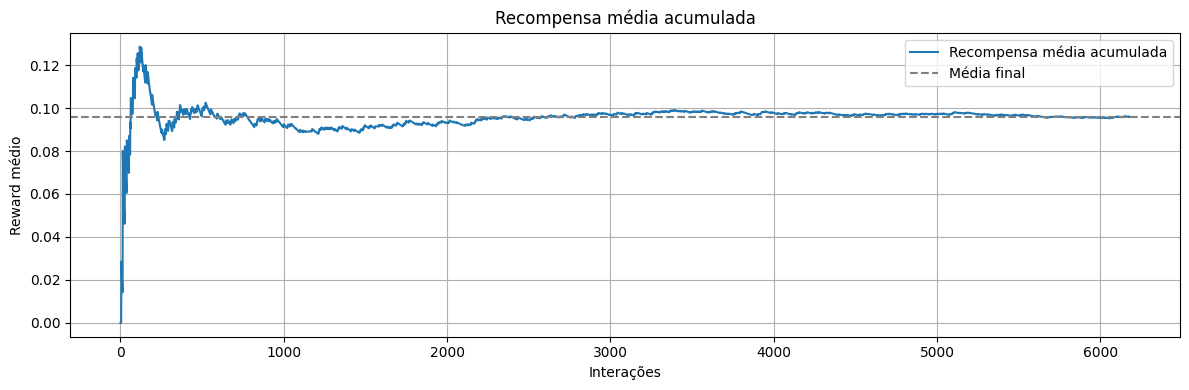

In [126]:
plt.figure(figsize=(12, 4))
plt.plot(results[1150086]['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(results[1150086]['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

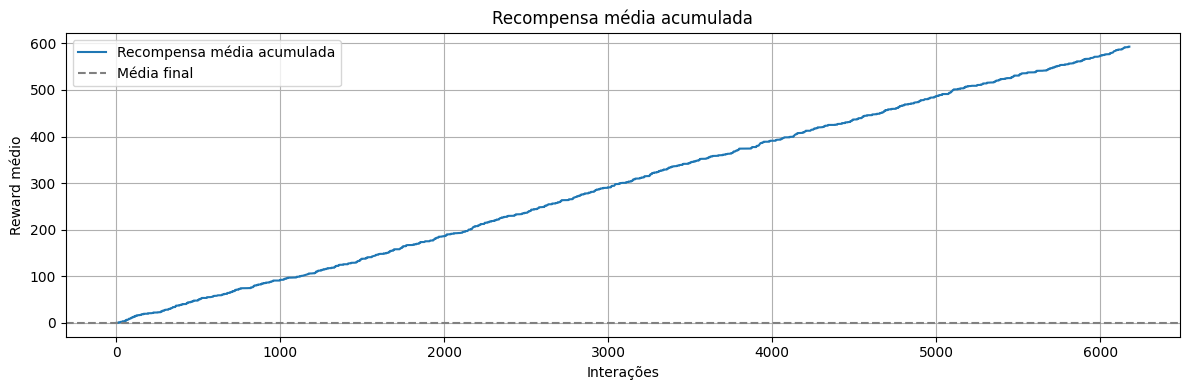

In [127]:
plt.figure(figsize=(12, 4))
plt.plot(results[1150086]['reward'].cumsum(), label='Recompensa média acumulada')
plt.axhline(results[1150086]['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()